<h3>导入包</h3>

In [1]:
import os
import logging
from datetime import datetime
from typing import Optional, Union
from chinese_calendar import is_workday, is_holiday, is_in_lieu, get_holiday_detail
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, Timestamp, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.base import RegressorMixin
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, History
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(42)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.compat.v1.reset_default_graph()
clear_session()


warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

<h3>读入数据</h3>

<h4>读入A榜数据</h4>

In [2]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])

<h4>读入B榜数据</h4>

In [3]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_B/' + name + '_EC_B.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)

<h4>读入C榜数据</h4>

In [4]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_Final/' + name + '_EC_Final.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)
data_dict

{'二层插座':                    time     value
 0   2013-08-03 00:00:00  0.164062
 1   2013-08-03 00:15:00  0.121094
 2   2013-08-03 00:30:00  0.101562
 3   2013-08-03 00:45:00  0.087891
 4   2013-08-03 01:00:00  0.103516
 ..                  ...       ...
 667 2015-08-17 22:45:00  0.085938
 668 2015-08-17 23:00:00  0.128906
 669 2015-08-17 23:15:00  0.082031
 670 2015-08-17 23:30:00  0.144531
 671 2015-08-17 23:45:00  0.093750
 
 [64744 rows x 2 columns], '二层照明':                    time     value
 0   2013-08-03 00:00:00  0.500000
 1   2013-08-03 00:15:00  0.507812
 2   2013-08-03 00:30:00  0.476562
 3   2013-08-03 00:45:00  0.117188
 4   2013-08-03 01:00:00  0.000000
 ..                  ...       ...
 667 2015-08-17 22:45:00  0.000000
 668 2015-08-17 23:00:00  0.000000
 669 2015-08-17 23:15:00  0.000000
 670 2015-08-17 23:30:00  0.000000
 671 2015-08-17 23:45:00  0.000000
 
 [64992 rows x 2 columns], '一层插座':                    time     value
 0   2013-08-03 00:00:00  0.113281
 1   2013-

<h3>读入天气数据</h3>

In [5]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh = wh.set_index("time", drop=True)
wh

,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,
2013-08-03 00:00:00,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,25,75,0.4,1007,东北风,35,7,2


<h3>合并数据</h3>

<h4>对齐数据</h4>

In [6]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

,time,value_socket_2,value_light_2,value_socket_1,value_light_1,value_air
0,2013-08-03 00:00:00,0.164062,0.500000,0.113281,0.542969,4.234375
1,2013-08-03 00:15:00,0.121094,0.507812,0.273438,0.542969,5.093750
2,2013-08-03 00:30:00,0.101562,0.476562,0.277344,0.515625,3.234375
3,2013-08-03 00:45:00,0.087891,0.117188,0.218750,0.437500,3.187500
4,2013-08-03 01:00:00,0.103516,0.000000,0.082031,0.406250,3.171875
...,...,...,...,...,...,...
64504,2015-08-17 22:45:00,0.085938,0.000000,0.089844,0.265625,1.937500
64505,2015-08-17 23:00:00,0.128906,0.000000,0.140625,0.265625,1.750000
64506,2015-08-17 23:15:00,0.082031,0.000000,0.093750,0.265625,1.843750
64507,2015-08-17 23:30:00,0.144531,0.000000,0.156250,0.265625,1.687500


<h4>将一二层数据相加</h4>

In [7]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data["value_total"] = data.sum(axis=1)
data = data.set_index("time", drop=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq="15T"))

<h3>处理缺失值</h3>

<h4>查看大段的nan</h4>

In [8]:
data.loc['2014-03-14 13:00:00' : '2014-04-23 20:15:00']

,value_air,value_socket,value_light,value_total
2014-03-14 13:00:00,2.43750,1.539062,1.710938,5.687500
2014-03-14 13:15:00,2.37500,1.769531,1.777344,5.921875
2014-03-14 13:30:00,2.37500,1.347656,1.882812,5.605469
2014-03-14 13:45:00,NaN,NaN,NaN,NaN
2014-03-14 14:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-04-23 19:15:00,NaN,NaN,NaN,NaN
2014-04-23 19:30:00,NaN,NaN,NaN,NaN
2014-04-23 19:45:00,NaN,NaN,NaN,NaN
2014-04-23 20:00:00,NaN,NaN,NaN,NaN


In [9]:
data.loc['2014-11-17 08:00:00' : '2014-12-10 17:15:00']

,value_air,value_socket,value_light,value_total
2014-11-17 08:00:00,0.59375,0.390625,0.320312,1.304688
2014-11-17 08:15:00,0.59375,0.207031,0.281250,1.082031
2014-11-17 08:30:00,NaN,NaN,NaN,NaN
2014-11-17 08:45:00,NaN,NaN,NaN,NaN
2014-11-17 09:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-12-10 16:15:00,NaN,NaN,NaN,NaN
2014-12-10 16:30:00,NaN,NaN,NaN,NaN
2014-12-10 16:45:00,11.62500,1.718750,2.039062,15.382812
2014-12-10 17:00:00,12.15625,1.757812,2.039062,15.953125


<h4>查看所有缺失值的index，并将该小时的Timestamp记录下来</h4>

In [10]:
nan_index = data[data["value_total"].isnull()].index
nan_index_hours = []
for idx in nan_index:
    nan_index_hour = Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=idx.hour)
    nan_index_hours.append(nan_index_hour)
nan_index_hours.extend(pd.date_range("2014-03-14 13:00:00", "2014-04-23 20:00:00", freq="1H").tolist())
nan_index_hours.extend(pd.date_range("2014-11-17 08:00:00", "2014-12-10 16:00:00", freq="1H").tolist())
nan_index_hours = np.unique(nan_index_hours)
DatetimeIndex(nan_index_hours)

DatetimeIndex(['2013-08-04 12:00:00', '2013-08-07 07:00:00',
               '2013-10-14 10:00:00', '2013-10-14 11:00:00',
               '2013-10-14 12:00:00', '2013-10-14 13:00:00',
               '2013-10-14 14:00:00', '2013-10-14 15:00:00',
               '2013-10-14 16:00:00', '2013-10-14 17:00:00',
               ...
               '2015-07-30 08:00:00', '2015-07-30 09:00:00',
               '2015-07-30 11:00:00', '2015-07-30 12:00:00',
               '2015-07-30 14:00:00', '2015-07-30 15:00:00',
               '2015-07-30 17:00:00', '2015-07-30 18:00:00',
               '2015-07-30 20:00:00', '2015-07-30 21:00:00'],
              dtype='datetime64[ns]', length=1860, freq=None)

<h4>对少数缺失值进行插值补全</h4>

In [11]:
data["value_air"] = data["value_air"].interpolate(method="time")
data["value_light"] = data["value_light"].interpolate(method="time")
data["value_socket"] = data["value_socket"].interpolate(method="time")
data["value_total"] = data["value_total"].interpolate(method="time")

<h3>按照每小时相加</h3>

In [12]:
data = data.resample("1H").sum()
data.loc["2014-03-14 13:00:00" : "2014-04-23 20:00:00", :] = np.nan
data.loc["2014-11-17 08:00:00" : "2014-12-10 16:00:00", :] = np.nan
data = data.dropna()
data

,value_air,value_socket,value_light,value_total
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484
...,...,...,...,...
2015-08-17 19:00:00,8.187500,1.015625,1.187500,10.390625
2015-08-17 20:00:00,8.031250,1.000000,0.937500,9.968750
2015-08-17 21:00:00,8.656250,1.007812,1.046875,10.710938
2015-08-17 22:00:00,7.468750,0.949219,1.156250,9.574219


<AxesSubplot:>

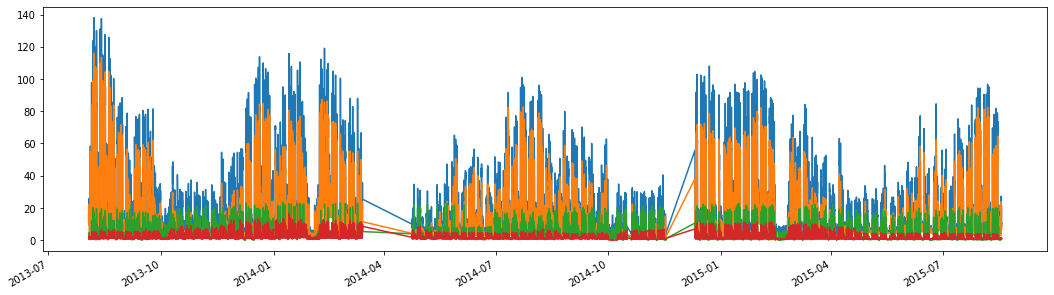

In [13]:
data["value_total"].plot(figsize=(18,5))
data["value_air"].plot(figsize=(18,5))
data["value_light"].plot(figsize=(18,5))
data["value_socket"].plot(figsize=(18,5))

<h3>合并天气数据</h3>

In [14]:
data = pd.merge(data, wh, how="right", left_index=True, right_index=True)
data

,value_air,value_socket,value_light,value_total,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,东北风,35,7,2


<h3>TODO 特征工程</h3>

<h4>修改列名</h4>

In [15]:
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})

<h4>自定义特征工程</h4>

In [16]:
data['workday'] = list(map(lambda x: int(is_workday(x)), data.index.to_list()))
data['hour'] = list(map(lambda x: x.hour, data.index.to_list()))
data['week'] = list(map(lambda x: x.weekday(), data.index.to_list()))
data['day'] = list(map(lambda x: x.day, data.index.to_list()))
data['month'] = list(map(lambda x: x.month, data.index.to_list()))
data['year'] = list(map(lambda x: x.year, data.index.to_list()))
data["date"] = list(map(lambda x: x.date(), data.index.to_list()))
data["wind_angle"] = data["wind_angle"].apply(lambda x: np.cos(np.pi / 180 * x))
data["is_summer"] = data["month"].apply(lambda x: x in (6, 7, 8)).astype(int)
data["is_winter"] = data["month"].apply(lambda x: x in (12, 1, 2)).astype(int)

mean_weather = data[["date", "temp", "humidity", "atmos", "wind_angle", "wind_speed", "cloud"]].groupby("date").mean()
sum_weather = data[["date", "rainfall"]].groupby("date").sum()
data = pd.merge(data.drop(columns=["temp", "humidity", "atmos", "wind_angle", "wind_speed", "cloud"]), mean_weather, how="inner", left_on="date", right_index=True)
data = pd.merge(data.drop(columns=["rainfall"]), sum_weather, how="inner", left_on="date", right_index=True)
data = data.drop(columns=["date"])

# data = pd.concat([data.loc[: "2015-08-03 23:00:00"].dropna(), data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]], axis=0)
data

,value_air,value_socket,value_light,value_total,wind_direction,workday,hour,week,day,month,year,is_summer,is_winter,temp,humidity,atmos,wind_angle,wind_speed,cloud,rainfall
time,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,东南风,0,0,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,东南风,0,1,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,东南风,0,2,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,东南风,0,3,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,东南风,0,4,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,东北风,1,19,0,24,8,2015,1,0,25.958333,71.541667,1006.958333,0.661124,12.250,41.166667,4.0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,东北风,1,20,0,24,8,2015,1,0,25.958333,71.541667,1006.958333,0.661124,12.250,41.166667,4.0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,东北风,1,21,0,24,8,2015,1,0,25.958333,71.541667,1006.958333,0.661124,12.250,41.166667,4.0


<h3>对类别特征onehot</h3>

<h4>对风向进行onehot</h4>

In [17]:
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data

,value_air,value_socket,value_light,value_total,workday,hour,week,day,month,year,...,cloud,rainfall,东北风,东南风,东风,北风,南风,西北风,西南风,西风
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,0,0,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,0,1,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,0,2,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,0,3,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,0,4,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,1,19,0,24,8,2015,...,41.166667,4.0,1,0,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,1,20,0,24,8,2015,...,41.166667,4.0,1,0,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,1,21,0,24,8,2015,...,41.166667,4.0,1,0,0,0,0,0,0,0


<h4>对星期几进行onehot</h4>

In [18]:
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["week"])
data

,value_air,value_socket,value_light,value_total,workday,hour,day,month,year,is_summer,...,西北风,西南风,西风,星期1,星期2,星期3,星期4,星期5,星期6,星期7
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,0,0,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,0,1,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,0,2,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,0,3,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,0,4,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,1,19,24,8,2015,1,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,1,20,24,8,2015,1,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,1,21,24,8,2015,1,...,0,0,0,1,0,0,0,0,0,0


<h3>构建模型</h3>

In [19]:
def r2_metric(y_pred, y_true):
    result1 = r2_score(y_true[0:24], y_pred[0:24])
    result2 = r2_score(y_true[24:48], y_pred[24:48])
    result3 = r2_score(y_true[48:72], y_pred[48:72])
    result4 = r2_score(y_true[72:96], y_pred[72:96])
    result5 = r2_score(y_true[96:120], y_pred[96:120])
    result6 = r2_score(y_true[120:144], y_pred[120:144])
    result7 = r2_score(y_true[144:168], y_pred[144:168])
    return "r2 score", 0.25 * result1 + 0.15 * (result2 + result3 + result4) + 0.1 * (result5 + result6 + result7), True

In [20]:
def cross_validation(estimator: RegressorMixin, n_splits: int, x_train_val: DataFrame, y_train_val: Series, x_test: DataFrame) -> np.ndarray:
    """
    交叉验证\n
    """
    models = []
    scores = []
    oof_preds = np.zeros((x_train_val.shape[0],))
    test_preds = np.zeros((x_test.shape[0],))
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train_val, y_train_val)):
        x_train, x_val, y_train, y_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index], y_train_val[train_index], y_train_val[val_index]

        estimator = estimator.fit(x_train, y_train, eval_set=(x_val, y_val), eval_metric=r2_metric, early_stopping_rounds=20)
        models.append(estimator)

        oof_preds[val_index] = estimator.predict(x_val, num_iteration=estimator.best_iteration_)
        test_preds += estimator.predict(x_test, num_iteration=estimator.best_iteration_) / kfold.n_splits
        score = r2_metric(y_val, estimator.predict(x_val, num_iteration=estimator.best_iteration_))[1]
        
        logging.info(f'############ fold: {fold}, r2: {score} ###########')
        scores.append(score)
    logging.info(f'############ cross validation r2 score: {np.mean(scores)} ###########')
    return test_preds

In [21]:
def shift_column(ser: Series, num: int) -> DataFrame:
    """
    取历史值\n
    """
    result = DataFrame()
    for i in range(1, num + 1):
        result["%s-%d" % (ser.name, i)] = ser.shift(i)
    return result

In [22]:
def clip_maxmin(ser: Series, _clip_min_: bool, _clip_max_: bool) -> Series:
    """
    把最小值最大值变为次小值次大值\n
    """
    result = ser.copy()
    if _clip_min_:
        idx = result.argmin()
        result[result == result.min()] = np.nan
        result.iloc[idx] = result.min()
    if _clip_max_:
        idx = result.argmax()
        result[result == result.max()] == np.nan
        result.iloc[idx] = result.max()
    return result

In [23]:
def clip_value(ser: Union[Series, np.ndarray], _min_val_: Optional[float] = None, _max_val_: Optional[float] = None) -> Series:
    """
    把小于最小值的替换成最小值\n
    """
    result = ser.copy()
    if _min_val_:
        result[result < _min_val_] = _min_val_
    if _max_val_:
        result[result > _max_val_] = _max_val_
    return result

In [24]:
@tf.function
def split_xy(x):
    return x[:, :, 1:], x[:, :, 0]

<h4>针对socket构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

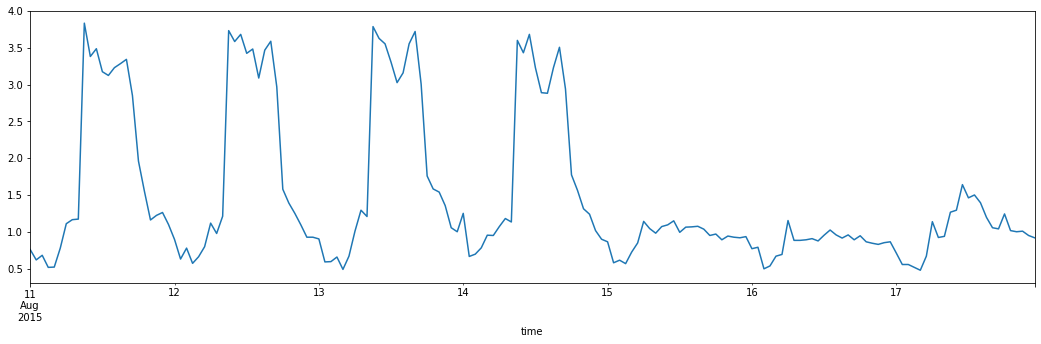

In [25]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [26]:
data_socket = data.drop(columns=["value_light", "value_air", "value_total"])
x_train_socket = data_socket.drop(columns=["value_socket"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_socket = data_socket["value_socket"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_socket = data_socket.drop(columns=["value_socket"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_socket.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [27]:
model_socket1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred1 = model_socket1.predict(x_test_socket)

<h5>取最后7*24个点作为模型2预测值</h5>

In [28]:
socket_pred2 = data_socket.loc[: "2015-08-17 23:00:00", "value_socket"].values[-7*24:]

<h5>构建catboost</h5>

In [29]:
model_socket3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred3 = model_socket3.predict(x_test_socket)

Learning rate set to 0.063462
0:	learn: 1.9021190	total: 64.3ms	remaining: 1m 4s
1:	learn: 1.8126397	total: 66.5ms	remaining: 33.2s
2:	learn: 1.7295371	total: 68.5ms	remaining: 22.8s
3:	learn: 1.6531055	total: 70.6ms	remaining: 17.6s
4:	learn: 1.5829596	total: 72.6ms	remaining: 14.5s
5:	learn: 1.5172177	total: 74.6ms	remaining: 12.4s
6:	learn: 1.4583006	total: 76.7ms	remaining: 10.9s
7:	learn: 1.4022904	total: 78.7ms	remaining: 9.75s
8:	learn: 1.3519502	total: 80.7ms	remaining: 8.88s
9:	learn: 1.3051437	total: 82.7ms	remaining: 8.19s
10:	learn: 1.2625295	total: 84.7ms	remaining: 7.62s
11:	learn: 1.2236371	total: 86.7ms	remaining: 7.14s
12:	learn: 1.1882331	total: 88.7ms	remaining: 6.73s
13:	learn: 1.1562660	total: 90.7ms	remaining: 6.39s
14:	learn: 1.1265692	total: 92.7ms	remaining: 6.08s
15:	learn: 1.0996298	total: 94.7ms	remaining: 5.83s
16:	learn: 1.0749785	total: 96.7ms	remaining: 5.59s
17:	learn: 1.0521629	total: 98.7ms	remaining: 5.38s
18:	learn: 1.0322155	total: 101ms	remaining:

234:	learn: 0.5655871	total: 527ms	remaining: 1.72s
235:	learn: 0.5650109	total: 530ms	remaining: 1.71s
236:	learn: 0.5646817	total: 531ms	remaining: 1.71s
237:	learn: 0.5642018	total: 533ms	remaining: 1.71s
238:	learn: 0.5638802	total: 535ms	remaining: 1.7s
239:	learn: 0.5633782	total: 538ms	remaining: 1.7s
240:	learn: 0.5629002	total: 540ms	remaining: 1.7s
241:	learn: 0.5624925	total: 541ms	remaining: 1.7s
242:	learn: 0.5619308	total: 543ms	remaining: 1.69s
243:	learn: 0.5616243	total: 545ms	remaining: 1.69s
244:	learn: 0.5611233	total: 548ms	remaining: 1.69s
245:	learn: 0.5608763	total: 550ms	remaining: 1.68s
246:	learn: 0.5604313	total: 552ms	remaining: 1.68s
247:	learn: 0.5599419	total: 554ms	remaining: 1.68s
248:	learn: 0.5593347	total: 556ms	remaining: 1.68s
249:	learn: 0.5589518	total: 557ms	remaining: 1.67s
250:	learn: 0.5583143	total: 559ms	remaining: 1.67s
251:	learn: 0.5576411	total: 561ms	remaining: 1.67s
252:	learn: 0.5571772	total: 564ms	remaining: 1.66s
253:	learn: 0.55

405:	learn: 0.5038967	total: 881ms	remaining: 1.29s
406:	learn: 0.5036349	total: 883ms	remaining: 1.29s
407:	learn: 0.5032268	total: 885ms	remaining: 1.28s
408:	learn: 0.5030320	total: 887ms	remaining: 1.28s
409:	learn: 0.5026903	total: 889ms	remaining: 1.28s
410:	learn: 0.5025009	total: 891ms	remaining: 1.28s
411:	learn: 0.5023397	total: 893ms	remaining: 1.27s
412:	learn: 0.5019776	total: 895ms	remaining: 1.27s
413:	learn: 0.5017484	total: 897ms	remaining: 1.27s
414:	learn: 0.5014275	total: 899ms	remaining: 1.27s
415:	learn: 0.5011950	total: 901ms	remaining: 1.26s
416:	learn: 0.5009795	total: 903ms	remaining: 1.26s
417:	learn: 0.5007340	total: 905ms	remaining: 1.26s
418:	learn: 0.5005717	total: 907ms	remaining: 1.26s
419:	learn: 0.5001857	total: 909ms	remaining: 1.25s
420:	learn: 0.4999300	total: 911ms	remaining: 1.25s
421:	learn: 0.4995445	total: 913ms	remaining: 1.25s
422:	learn: 0.4993532	total: 915ms	remaining: 1.25s
423:	learn: 0.4991705	total: 917ms	remaining: 1.25s
424:	learn: 

595:	learn: 0.4646686	total: 1.26s	remaining: 856ms
596:	learn: 0.4645291	total: 1.26s	remaining: 853ms
597:	learn: 0.4643617	total: 1.27s	remaining: 851ms
598:	learn: 0.4641742	total: 1.27s	remaining: 849ms
599:	learn: 0.4640487	total: 1.27s	remaining: 847ms
600:	learn: 0.4639135	total: 1.27s	remaining: 845ms
601:	learn: 0.4637746	total: 1.27s	remaining: 843ms
602:	learn: 0.4636440	total: 1.28s	remaining: 841ms
603:	learn: 0.4634417	total: 1.28s	remaining: 838ms
604:	learn: 0.4632470	total: 1.28s	remaining: 836ms
605:	learn: 0.4629989	total: 1.28s	remaining: 834ms
606:	learn: 0.4628884	total: 1.28s	remaining: 832ms
607:	learn: 0.4627466	total: 1.29s	remaining: 830ms
608:	learn: 0.4626717	total: 1.29s	remaining: 827ms
609:	learn: 0.4624709	total: 1.29s	remaining: 825ms
610:	learn: 0.4623259	total: 1.29s	remaining: 823ms
611:	learn: 0.4620625	total: 1.29s	remaining: 821ms
612:	learn: 0.4619630	total: 1.3s	remaining: 819ms
613:	learn: 0.4618307	total: 1.3s	remaining: 816ms
614:	learn: 0.

778:	learn: 0.4376528	total: 1.62s	remaining: 461ms
779:	learn: 0.4374896	total: 1.63s	remaining: 459ms
780:	learn: 0.4374364	total: 1.63s	remaining: 456ms
781:	learn: 0.4372876	total: 1.63s	remaining: 454ms
782:	learn: 0.4371832	total: 1.63s	remaining: 452ms
783:	learn: 0.4371046	total: 1.63s	remaining: 450ms
784:	learn: 0.4369063	total: 1.64s	remaining: 448ms
785:	learn: 0.4367747	total: 1.64s	remaining: 446ms
786:	learn: 0.4366318	total: 1.64s	remaining: 444ms
787:	learn: 0.4365163	total: 1.64s	remaining: 442ms
788:	learn: 0.4363888	total: 1.64s	remaining: 440ms
789:	learn: 0.4360947	total: 1.65s	remaining: 437ms
790:	learn: 0.4359269	total: 1.65s	remaining: 435ms
791:	learn: 0.4358452	total: 1.65s	remaining: 433ms
792:	learn: 0.4355851	total: 1.65s	remaining: 431ms
793:	learn: 0.4355044	total: 1.65s	remaining: 429ms
794:	learn: 0.4353899	total: 1.66s	remaining: 427ms
795:	learn: 0.4352582	total: 1.66s	remaining: 425ms
796:	learn: 0.4351217	total: 1.66s	remaining: 423ms
797:	learn: 

964:	learn: 0.4169771	total: 1.99s	remaining: 72.2ms
965:	learn: 0.4168290	total: 1.99s	remaining: 70.1ms
966:	learn: 0.4167128	total: 1.99s	remaining: 68.1ms
967:	learn: 0.4166338	total: 2s	remaining: 66ms
968:	learn: 0.4165660	total: 2s	remaining: 64ms
969:	learn: 0.4164848	total: 2s	remaining: 61.9ms
970:	learn: 0.4164081	total: 2s	remaining: 59.8ms
971:	learn: 0.4163621	total: 2s	remaining: 57.8ms
972:	learn: 0.4162779	total: 2.01s	remaining: 55.7ms
973:	learn: 0.4162055	total: 2.01s	remaining: 53.6ms
974:	learn: 0.4161540	total: 2.01s	remaining: 51.6ms
975:	learn: 0.4160175	total: 2.01s	remaining: 49.5ms
976:	learn: 0.4159252	total: 2.02s	remaining: 47.5ms
977:	learn: 0.4158680	total: 2.02s	remaining: 45.4ms
978:	learn: 0.4157105	total: 2.02s	remaining: 43.3ms
979:	learn: 0.4156303	total: 2.02s	remaining: 41.3ms
980:	learn: 0.4155970	total: 2.02s	remaining: 39.2ms
981:	learn: 0.4155352	total: 2.03s	remaining: 37.1ms
982:	learn: 0.4154904	total: 2.03s	remaining: 35.1ms
983:	learn: 

<h5>构建xgboost</h5>

In [30]:
model_socket4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_socket, y_train_socket)
socket_pred4 = model_socket4.predict(x_test_socket)

<h5>构建深度模型</h5>

In [31]:
ds_socket1 = timeseries_dataset_from_array(
    data=data_socket.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket2 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket3 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket = ds_socket1.concatenate(ds_socket2).concatenate(ds_socket3).map(split_xy)
ds_socket

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [32]:
model_socket5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_socket.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_socket5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_socket5.load_weights("../models/LSTM_socket_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_socket_final.h5")
except (OSError, ValueError) as e:
    history: History = model_socket5.fit(
        ds_socket,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_socket5.save_weights("../models/LSTM_socket_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_socket_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-28 08:42:51,518 [INFO] loading LSTM model from ../models/LSTM_socket_final.h5


In [33]:
socket_pred5 = model_socket5.predict(np.expand_dims(x_test_socket.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

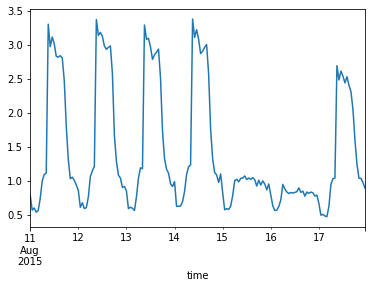

In [34]:
socket_pred = (socket_pred1 + socket_pred2 + socket_pred3 + socket_pred4) / 4
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"] = socket_pred
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot()

<h4>针对light构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

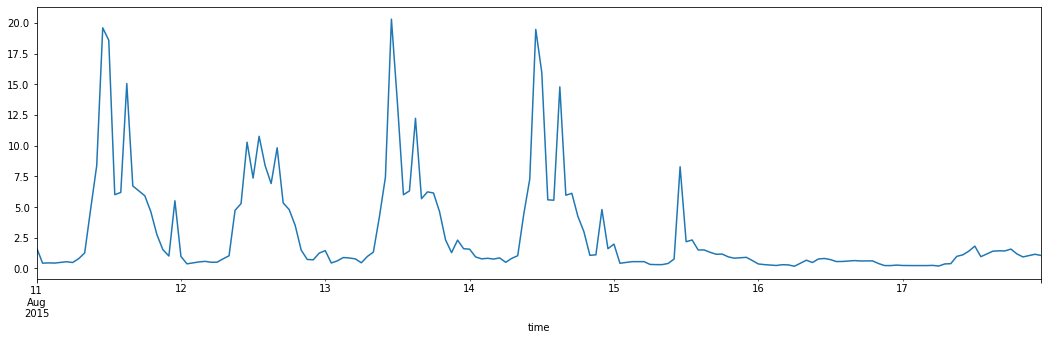

In [35]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [36]:
data_light = data.drop(columns=["value_socket", "value_air", "value_total", 'temp', 'humidity', 'atmos', 'wind_angle', 'wind_speed'])
x_train_light = data_light.drop(columns=["value_light"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_light = data_light["value_light"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_light = data_light.drop(columns=["value_light"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_light.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [37]:
model_light1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred1 = model_light1.predict(x_test_light)

<h5>取最后7*24个点作为模型2预测值</h5>

In [38]:
light_pred2 = data_light.loc[: "2015-08-17 23:00:00", "value_light"].values[-7*24:]

<h5>构建catboost</h5>

In [39]:
model_light3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred3 = model_light3.predict(x_test_light)

Learning rate set to 0.063462
0:	learn: 3.5540881	total: 2.63ms	remaining: 2.63s
1:	learn: 3.3893379	total: 5.07ms	remaining: 2.53s
2:	learn: 3.2378582	total: 7.46ms	remaining: 2.48s
3:	learn: 3.0988288	total: 9.74ms	remaining: 2.42s
4:	learn: 2.9714656	total: 12ms	remaining: 2.4s
5:	learn: 2.8552029	total: 14.4ms	remaining: 2.38s
6:	learn: 2.7462927	total: 16.6ms	remaining: 2.35s
7:	learn: 2.6491827	total: 18.9ms	remaining: 2.34s
8:	learn: 2.5585888	total: 21.5ms	remaining: 2.37s
9:	learn: 2.4750524	total: 23.9ms	remaining: 2.37s
10:	learn: 2.3994791	total: 26.2ms	remaining: 2.35s
11:	learn: 2.3320206	total: 28.5ms	remaining: 2.34s
12:	learn: 2.2687804	total: 30.7ms	remaining: 2.33s
13:	learn: 2.2078399	total: 32.9ms	remaining: 2.32s
14:	learn: 2.1514234	total: 35.1ms	remaining: 2.3s
15:	learn: 2.1065493	total: 37.3ms	remaining: 2.29s
16:	learn: 2.0580619	total: 39.5ms	remaining: 2.28s
17:	learn: 2.0164637	total: 41.7ms	remaining: 2.27s
18:	learn: 1.9787386	total: 43.9ms	remaining: 2.

175:	learn: 1.3479762	total: 353ms	remaining: 1.65s
176:	learn: 1.3471821	total: 355ms	remaining: 1.65s
177:	learn: 1.3453380	total: 357ms	remaining: 1.65s
178:	learn: 1.3444545	total: 358ms	remaining: 1.64s
179:	learn: 1.3433610	total: 360ms	remaining: 1.64s
180:	learn: 1.3421668	total: 362ms	remaining: 1.64s
181:	learn: 1.3406356	total: 364ms	remaining: 1.64s
182:	learn: 1.3398626	total: 366ms	remaining: 1.64s
183:	learn: 1.3390635	total: 368ms	remaining: 1.63s
184:	learn: 1.3382592	total: 370ms	remaining: 1.63s
185:	learn: 1.3374828	total: 372ms	remaining: 1.63s
186:	learn: 1.3355243	total: 375ms	remaining: 1.63s
187:	learn: 1.3341595	total: 377ms	remaining: 1.63s
188:	learn: 1.3334726	total: 379ms	remaining: 1.63s
189:	learn: 1.3325750	total: 381ms	remaining: 1.62s
190:	learn: 1.3316023	total: 383ms	remaining: 1.62s
191:	learn: 1.3305216	total: 385ms	remaining: 1.62s
192:	learn: 1.3294001	total: 387ms	remaining: 1.62s
193:	learn: 1.3283225	total: 389ms	remaining: 1.61s
194:	learn: 

367:	learn: 1.2023379	total: 722ms	remaining: 1.24s
368:	learn: 1.2017816	total: 724ms	remaining: 1.24s
369:	learn: 1.2010935	total: 726ms	remaining: 1.24s
370:	learn: 1.2006388	total: 728ms	remaining: 1.23s
371:	learn: 1.1999853	total: 730ms	remaining: 1.23s
372:	learn: 1.1994737	total: 732ms	remaining: 1.23s
373:	learn: 1.1990807	total: 734ms	remaining: 1.23s
374:	learn: 1.1984001	total: 736ms	remaining: 1.23s
375:	learn: 1.1979828	total: 738ms	remaining: 1.23s
376:	learn: 1.1977782	total: 740ms	remaining: 1.22s
377:	learn: 1.1970329	total: 742ms	remaining: 1.22s
378:	learn: 1.1966788	total: 744ms	remaining: 1.22s
379:	learn: 1.1962476	total: 746ms	remaining: 1.22s
380:	learn: 1.1957486	total: 748ms	remaining: 1.21s
381:	learn: 1.1951277	total: 750ms	remaining: 1.21s
382:	learn: 1.1944213	total: 752ms	remaining: 1.21s
383:	learn: 1.1938164	total: 754ms	remaining: 1.21s
384:	learn: 1.1932448	total: 756ms	remaining: 1.21s
385:	learn: 1.1929229	total: 757ms	remaining: 1.2s
386:	learn: 1

548:	learn: 1.1230034	total: 1.07s	remaining: 884ms
549:	learn: 1.1228011	total: 1.08s	remaining: 882ms
550:	learn: 1.1221860	total: 1.08s	remaining: 880ms
551:	learn: 1.1214825	total: 1.08s	remaining: 878ms
552:	learn: 1.1211678	total: 1.08s	remaining: 876ms
553:	learn: 1.1207582	total: 1.08s	remaining: 874ms
554:	learn: 1.1205168	total: 1.09s	remaining: 872ms
555:	learn: 1.1195646	total: 1.09s	remaining: 870ms
556:	learn: 1.1191252	total: 1.09s	remaining: 868ms
557:	learn: 1.1187252	total: 1.09s	remaining: 866ms
558:	learn: 1.1183599	total: 1.09s	remaining: 864ms
559:	learn: 1.1178465	total: 1.1s	remaining: 862ms
560:	learn: 1.1173805	total: 1.1s	remaining: 860ms
561:	learn: 1.1169818	total: 1.1s	remaining: 858ms
562:	learn: 1.1167064	total: 1.1s	remaining: 856ms
563:	learn: 1.1163587	total: 1.1s	remaining: 854ms
564:	learn: 1.1160314	total: 1.11s	remaining: 852ms
565:	learn: 1.1155735	total: 1.11s	remaining: 850ms
566:	learn: 1.1150310	total: 1.11s	remaining: 848ms
567:	learn: 1.114

735:	learn: 1.0552075	total: 1.44s	remaining: 515ms
736:	learn: 1.0548272	total: 1.44s	remaining: 513ms
737:	learn: 1.0544816	total: 1.44s	remaining: 511ms
738:	learn: 1.0542943	total: 1.44s	remaining: 509ms
739:	learn: 1.0540130	total: 1.44s	remaining: 507ms
740:	learn: 1.0535657	total: 1.45s	remaining: 505ms
741:	learn: 1.0533647	total: 1.45s	remaining: 503ms
742:	learn: 1.0531111	total: 1.45s	remaining: 501ms
743:	learn: 1.0526747	total: 1.45s	remaining: 500ms
744:	learn: 1.0525143	total: 1.45s	remaining: 498ms
745:	learn: 1.0520262	total: 1.46s	remaining: 496ms
746:	learn: 1.0517684	total: 1.46s	remaining: 494ms
747:	learn: 1.0511426	total: 1.46s	remaining: 492ms
748:	learn: 1.0509380	total: 1.46s	remaining: 490ms
749:	learn: 1.0508188	total: 1.46s	remaining: 488ms
750:	learn: 1.0506613	total: 1.47s	remaining: 486ms
751:	learn: 1.0503131	total: 1.47s	remaining: 484ms
752:	learn: 1.0499942	total: 1.47s	remaining: 482ms
753:	learn: 1.0497060	total: 1.47s	remaining: 480ms
754:	learn: 

923:	learn: 1.0035192	total: 1.8s	remaining: 148ms
924:	learn: 1.0033234	total: 1.8s	remaining: 146ms
925:	learn: 1.0028074	total: 1.8s	remaining: 144ms
926:	learn: 1.0026817	total: 1.8s	remaining: 142ms
927:	learn: 1.0024872	total: 1.8s	remaining: 140ms
928:	learn: 1.0023571	total: 1.81s	remaining: 138ms
929:	learn: 1.0021485	total: 1.81s	remaining: 136ms
930:	learn: 1.0017835	total: 1.81s	remaining: 134ms
931:	learn: 1.0015737	total: 1.81s	remaining: 132ms
932:	learn: 1.0013942	total: 1.81s	remaining: 130ms
933:	learn: 1.0011433	total: 1.82s	remaining: 128ms
934:	learn: 1.0009897	total: 1.82s	remaining: 126ms
935:	learn: 1.0008370	total: 1.82s	remaining: 125ms
936:	learn: 1.0003818	total: 1.82s	remaining: 123ms
937:	learn: 1.0002329	total: 1.82s	remaining: 121ms
938:	learn: 1.0000632	total: 1.83s	remaining: 119ms
939:	learn: 0.9998532	total: 1.83s	remaining: 117ms
940:	learn: 0.9996803	total: 1.83s	remaining: 115ms
941:	learn: 0.9993023	total: 1.83s	remaining: 113ms
942:	learn: 0.998

<h5>构建xgboost</h5>

In [40]:
model_light4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_light, y_train_light)
light_pred4 = model_light4.predict(x_test_light)

<h5>构建深度模型</h5>

In [41]:
ds_light1 = timeseries_dataset_from_array(
    data=data_light.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light2 = timeseries_dataset_from_array(
    data=data_light.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light3 = timeseries_dataset_from_array(
    data=data_light.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light = ds_light1.concatenate(ds_light2).concatenate(ds_light3).map(split_xy)
ds_light

<MapDataset shapes: ((None, None, 24), (None, None)), types: (tf.float64, tf.float64)>

In [42]:
model_light5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_light.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_light5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_light5.load_weights("../models/LSTM_light_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_light_final.h5")
except (OSError, ValueError) as e:
    history: History = model_light5.fit(
        ds_light,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_light_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_light_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-28 08:43:01,114 [INFO] loading LSTM model from ../models/LSTM_light_final.h5


In [43]:
light_pred5 = model_light5.predict(np.expand_dims(x_test_light.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

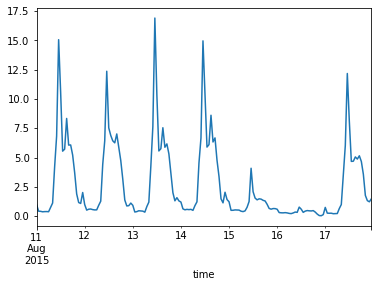

In [44]:
light_pred = (light_pred1 + light_pred2 + light_pred3 + light_pred4) / 4
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"] = light_pred
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot()

<h4>针对air构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

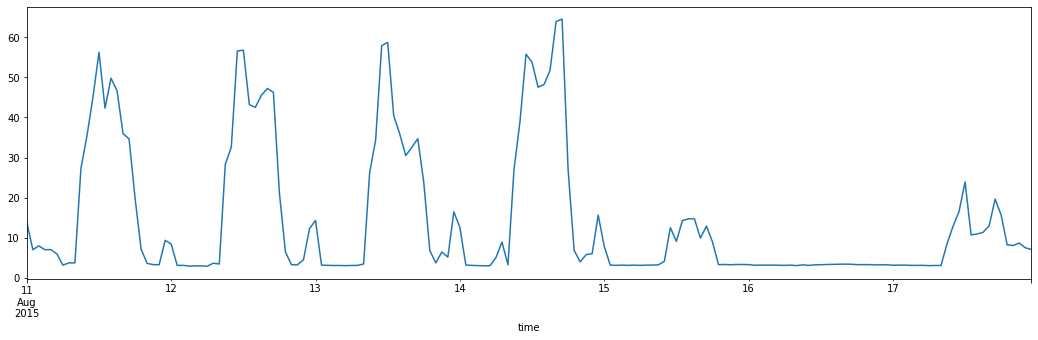

In [45]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [46]:
data_air = data.drop(columns=["value_socket", "value_light", "value_total"])
x_train_air = data_air.drop(columns=["value_air"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_air = data_air["value_air"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_air = data_air.drop(columns=["value_air"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_air.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [47]:
model_air1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred1 = model_air1.predict(x_test_air)

<h5>取最后7*24个点作为模型2预测值</h5>

In [48]:
air_pred2 = data_air.loc[: "2015-08-17 23:00:00", "value_air"].values[-7*24:]

<h5>构建catboost</h5>

In [49]:
model_air3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred3 = model_air3.predict(x_test_air)

Learning rate set to 0.063462
0:	learn: 14.1219252	total: 2.88ms	remaining: 2.87s
1:	learn: 13.5629992	total: 5.45ms	remaining: 2.72s
2:	learn: 13.0535653	total: 7.99ms	remaining: 2.66s
3:	learn: 12.5761175	total: 10.4ms	remaining: 2.59s
4:	learn: 12.1192898	total: 12.8ms	remaining: 2.54s
5:	learn: 11.7115226	total: 15.2ms	remaining: 2.52s
6:	learn: 11.3453532	total: 17.7ms	remaining: 2.51s
7:	learn: 11.0140004	total: 20.1ms	remaining: 2.5s
8:	learn: 10.6898685	total: 22.5ms	remaining: 2.47s
9:	learn: 10.3979704	total: 24.8ms	remaining: 2.46s
10:	learn: 10.1300857	total: 27.2ms	remaining: 2.44s
11:	learn: 9.8844832	total: 29.5ms	remaining: 2.43s
12:	learn: 9.6610335	total: 31.9ms	remaining: 2.42s
13:	learn: 9.4508369	total: 34.3ms	remaining: 2.41s
14:	learn: 9.2570145	total: 36.5ms	remaining: 2.4s
15:	learn: 9.0886974	total: 38.9ms	remaining: 2.4s
16:	learn: 8.9277281	total: 41.4ms	remaining: 2.39s
17:	learn: 8.7845241	total: 43.7ms	remaining: 2.39s
18:	learn: 8.6553853	total: 46ms	rem

166:	learn: 5.2161037	total: 348ms	remaining: 1.74s
167:	learn: 5.2078253	total: 350ms	remaining: 1.73s
168:	learn: 5.2009720	total: 352ms	remaining: 1.73s
169:	learn: 5.1948162	total: 354ms	remaining: 1.73s
170:	learn: 5.1884364	total: 356ms	remaining: 1.73s
171:	learn: 5.1830285	total: 359ms	remaining: 1.73s
172:	learn: 5.1755317	total: 361ms	remaining: 1.73s
173:	learn: 5.1680977	total: 363ms	remaining: 1.72s
174:	learn: 5.1622114	total: 366ms	remaining: 1.72s
175:	learn: 5.1543891	total: 368ms	remaining: 1.72s
176:	learn: 5.1481445	total: 370ms	remaining: 1.72s
177:	learn: 5.1420197	total: 372ms	remaining: 1.72s
178:	learn: 5.1362343	total: 374ms	remaining: 1.71s
179:	learn: 5.1292068	total: 376ms	remaining: 1.71s
180:	learn: 5.1196115	total: 378ms	remaining: 1.71s
181:	learn: 5.1143055	total: 380ms	remaining: 1.71s
182:	learn: 5.1068366	total: 382ms	remaining: 1.71s
183:	learn: 5.0995499	total: 384ms	remaining: 1.7s
184:	learn: 5.0944287	total: 386ms	remaining: 1.7s
185:	learn: 5.

346:	learn: 4.2982587	total: 717ms	remaining: 1.35s
347:	learn: 4.2949507	total: 719ms	remaining: 1.35s
348:	learn: 4.2916092	total: 721ms	remaining: 1.34s
349:	learn: 4.2865438	total: 723ms	remaining: 1.34s
350:	learn: 4.2834616	total: 725ms	remaining: 1.34s
351:	learn: 4.2784958	total: 727ms	remaining: 1.34s
352:	learn: 4.2749831	total: 730ms	remaining: 1.34s
353:	learn: 4.2708310	total: 732ms	remaining: 1.33s
354:	learn: 4.2666128	total: 734ms	remaining: 1.33s
355:	learn: 4.2634707	total: 736ms	remaining: 1.33s
356:	learn: 4.2607030	total: 738ms	remaining: 1.33s
357:	learn: 4.2559893	total: 740ms	remaining: 1.33s
358:	learn: 4.2531027	total: 742ms	remaining: 1.32s
359:	learn: 4.2499149	total: 744ms	remaining: 1.32s
360:	learn: 4.2462458	total: 746ms	remaining: 1.32s
361:	learn: 4.2423463	total: 748ms	remaining: 1.32s
362:	learn: 4.2406144	total: 750ms	remaining: 1.31s
363:	learn: 4.2367641	total: 752ms	remaining: 1.31s
364:	learn: 4.2343960	total: 754ms	remaining: 1.31s
365:	learn: 

521:	learn: 3.8191604	total: 1.07s	remaining: 980ms
522:	learn: 3.8173497	total: 1.07s	remaining: 978ms
523:	learn: 3.8157086	total: 1.07s	remaining: 976ms
524:	learn: 3.8141330	total: 1.08s	remaining: 974ms
525:	learn: 3.8122100	total: 1.08s	remaining: 972ms
526:	learn: 3.8103369	total: 1.08s	remaining: 970ms
527:	learn: 3.8079720	total: 1.08s	remaining: 968ms
528:	learn: 3.8066827	total: 1.08s	remaining: 966ms
529:	learn: 3.8053909	total: 1.09s	remaining: 964ms
530:	learn: 3.8031979	total: 1.09s	remaining: 962ms
531:	learn: 3.8017752	total: 1.09s	remaining: 960ms
532:	learn: 3.8005699	total: 1.09s	remaining: 958ms
533:	learn: 3.7988109	total: 1.09s	remaining: 956ms
534:	learn: 3.7973535	total: 1.1s	remaining: 954ms
535:	learn: 3.7957031	total: 1.1s	remaining: 952ms
536:	learn: 3.7941560	total: 1.1s	remaining: 949ms
537:	learn: 3.7925972	total: 1.1s	remaining: 947ms
538:	learn: 3.7913042	total: 1.1s	remaining: 945ms
539:	learn: 3.7895684	total: 1.11s	remaining: 943ms
540:	learn: 3.787

699:	learn: 3.5044308	total: 1.43s	remaining: 613ms
700:	learn: 3.5023383	total: 1.43s	remaining: 611ms
701:	learn: 3.5010202	total: 1.43s	remaining: 609ms
702:	learn: 3.4999198	total: 1.44s	remaining: 607ms
703:	learn: 3.4990591	total: 1.44s	remaining: 604ms
704:	learn: 3.4974453	total: 1.44s	remaining: 602ms
705:	learn: 3.4965578	total: 1.44s	remaining: 600ms
706:	learn: 3.4951971	total: 1.44s	remaining: 598ms
707:	learn: 3.4943130	total: 1.45s	remaining: 596ms
708:	learn: 3.4921859	total: 1.45s	remaining: 594ms
709:	learn: 3.4912672	total: 1.45s	remaining: 592ms
710:	learn: 3.4879531	total: 1.45s	remaining: 590ms
711:	learn: 3.4864571	total: 1.45s	remaining: 588ms
712:	learn: 3.4851122	total: 1.46s	remaining: 586ms
713:	learn: 3.4834372	total: 1.46s	remaining: 584ms
714:	learn: 3.4821561	total: 1.46s	remaining: 582ms
715:	learn: 3.4814663	total: 1.46s	remaining: 580ms
716:	learn: 3.4800510	total: 1.46s	remaining: 578ms
717:	learn: 3.4782820	total: 1.47s	remaining: 576ms
718:	learn: 

878:	learn: 3.2751746	total: 1.79s	remaining: 247ms
879:	learn: 3.2740544	total: 1.8s	remaining: 245ms
880:	learn: 3.2733211	total: 1.8s	remaining: 243ms
881:	learn: 3.2717794	total: 1.8s	remaining: 241ms
882:	learn: 3.2701408	total: 1.8s	remaining: 239ms
883:	learn: 3.2698305	total: 1.8s	remaining: 237ms
884:	learn: 3.2688665	total: 1.81s	remaining: 235ms
885:	learn: 3.2678231	total: 1.81s	remaining: 233ms
886:	learn: 3.2665617	total: 1.81s	remaining: 231ms
887:	learn: 3.2653941	total: 1.81s	remaining: 229ms
888:	learn: 3.2649131	total: 1.81s	remaining: 227ms
889:	learn: 3.2632223	total: 1.82s	remaining: 225ms
890:	learn: 3.2624181	total: 1.82s	remaining: 223ms
891:	learn: 3.2605706	total: 1.82s	remaining: 221ms
892:	learn: 3.2594386	total: 1.82s	remaining: 218ms
893:	learn: 3.2589293	total: 1.82s	remaining: 216ms
894:	learn: 3.2580237	total: 1.83s	remaining: 214ms
895:	learn: 3.2563774	total: 1.83s	remaining: 212ms
896:	learn: 3.2556626	total: 1.83s	remaining: 210ms
897:	learn: 3.254

<h5>构建xgboost</h5>

In [50]:
model_air4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_air.loc[y_train_air > 0], y_train_air[y_train_air > 0])
air_pred4 = model_air4.predict(x_test_air)

<h5>构建深度模型</h5>

In [51]:
ds_air1 = timeseries_dataset_from_array(
    data=data_air.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air2 = timeseries_dataset_from_array(
    data=data_air.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air3 = timeseries_dataset_from_array(
    data=data_air.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air = ds_air1.concatenate(ds_air2).concatenate(ds_air3).map(split_xy)
ds_air

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [52]:
model_air5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_air.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_air5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_air5.load_weights("../models/LSTM_air_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_air_final.h5")
except (OSError, ValueError) as e:
    history: History = model_air5.fit(
        ds_air,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_air5.save_weights("../models/LSTM_air_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_air_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-28 08:43:07,738 [INFO] loading LSTM model from ../models/LSTM_air_final.h5


In [53]:
air_pred5 = model_air5.predict(np.expand_dims(x_test_air.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

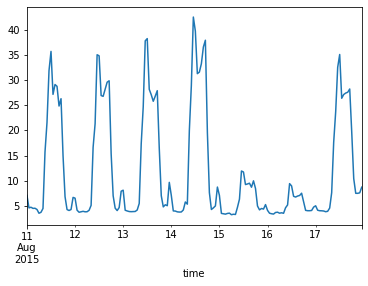

In [54]:
air_pred = (air_pred1 + air_pred2 + air_pred3 + air_pred4) / 4
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"] = air_pred
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot()

<h4>针对total构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

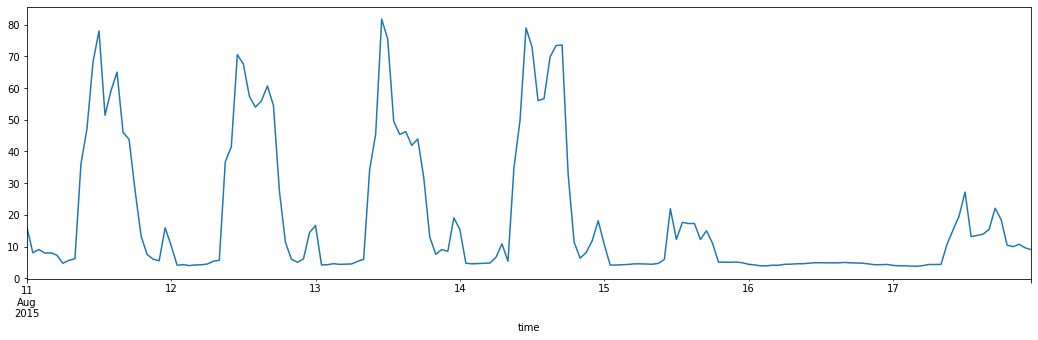

In [55]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [56]:
data_total = data.drop(columns=["value_socket", "value_light", "value_air"])
x_train_total = data_total.drop(columns=["value_total"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = data_total["value_total"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = y_train_total[y_train_total > 0]
x_train_total = x_train_total.loc[y_train_total.index]
x_test_total = data_total.drop(columns=["value_total"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_total.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [57]:
model_total1 = LGBMRegressor(n_estimators=10000, n_jobs=-1, random_state=42).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred1 = model_total1.predict(x_test_total)

<h5>取最后7*24个点作为模型2预测值</h5>

In [58]:
total_pred2 = data_total.loc[: "2015-08-17 23:00:00", "value_total"].values[-7*24:]

<h5>构建catboost</h5>

In [59]:
model_total3 = CatBoostRegressor(n_estimators=10000, random_state=1024).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred3 = model_total3.predict(x_test_total)

Learning rate set to 0.009761
0:	learn: 18.6838380	total: 3.04ms	remaining: 30.4s
1:	learn: 18.5529068	total: 12.5ms	remaining: 1m 2s
2:	learn: 18.4235950	total: 15.3ms	remaining: 51.1s
3:	learn: 18.2960545	total: 17.9ms	remaining: 44.8s
4:	learn: 18.1699330	total: 20.6ms	remaining: 41.1s
5:	learn: 18.0456743	total: 23.1ms	remaining: 38.6s
6:	learn: 17.9228884	total: 25.7ms	remaining: 36.7s
7:	learn: 17.8013725	total: 28.2ms	remaining: 35.2s
8:	learn: 17.6813157	total: 30.8ms	remaining: 34.2s
9:	learn: 17.5627972	total: 33.3ms	remaining: 33.3s
10:	learn: 17.4456095	total: 35.8ms	remaining: 32.5s
11:	learn: 17.3298103	total: 38.4ms	remaining: 32s
12:	learn: 17.2154361	total: 41.1ms	remaining: 31.6s
13:	learn: 17.1025287	total: 43.8ms	remaining: 31.2s
14:	learn: 16.9908058	total: 46.4ms	remaining: 30.9s
15:	learn: 16.8805176	total: 48.8ms	remaining: 30.4s
16:	learn: 16.7716156	total: 51ms	remaining: 30s
17:	learn: 16.6641191	total: 53.5ms	remaining: 29.6s
18:	learn: 16.5561845	total: 55.

231:	learn: 8.6520373	total: 536ms	remaining: 22.6s
232:	learn: 8.6427457	total: 538ms	remaining: 22.6s
233:	learn: 8.6338773	total: 541ms	remaining: 22.6s
234:	learn: 8.6222496	total: 543ms	remaining: 22.6s
235:	learn: 8.6133379	total: 545ms	remaining: 22.5s
236:	learn: 8.6042747	total: 547ms	remaining: 22.5s
237:	learn: 8.5957967	total: 549ms	remaining: 22.5s
238:	learn: 8.5860976	total: 552ms	remaining: 22.5s
239:	learn: 8.5757643	total: 554ms	remaining: 22.5s
240:	learn: 8.5646956	total: 556ms	remaining: 22.5s
241:	learn: 8.5554850	total: 558ms	remaining: 22.5s
242:	learn: 8.5470530	total: 560ms	remaining: 22.5s
243:	learn: 8.5359537	total: 562ms	remaining: 22.5s
244:	learn: 8.5259043	total: 565ms	remaining: 22.5s
245:	learn: 8.5186782	total: 567ms	remaining: 22.5s
246:	learn: 8.5108952	total: 569ms	remaining: 22.5s
247:	learn: 8.5018119	total: 571ms	remaining: 22.5s
248:	learn: 8.4908804	total: 573ms	remaining: 22.4s
249:	learn: 8.4840214	total: 575ms	remaining: 22.4s
250:	learn: 

392:	learn: 7.5906065	total: 885ms	remaining: 21.6s
393:	learn: 7.5860610	total: 887ms	remaining: 21.6s
394:	learn: 7.5820073	total: 889ms	remaining: 21.6s
395:	learn: 7.5771930	total: 892ms	remaining: 21.6s
396:	learn: 7.5719413	total: 894ms	remaining: 21.6s
397:	learn: 7.5683195	total: 896ms	remaining: 21.6s
398:	learn: 7.5632155	total: 898ms	remaining: 21.6s
399:	learn: 7.5578598	total: 900ms	remaining: 21.6s
400:	learn: 7.5526599	total: 903ms	remaining: 21.6s
401:	learn: 7.5480002	total: 905ms	remaining: 21.6s
402:	learn: 7.5436331	total: 907ms	remaining: 21.6s
403:	learn: 7.5378958	total: 909ms	remaining: 21.6s
404:	learn: 7.5331861	total: 911ms	remaining: 21.6s
405:	learn: 7.5282820	total: 913ms	remaining: 21.6s
406:	learn: 7.5247293	total: 916ms	remaining: 21.6s
407:	learn: 7.5197525	total: 918ms	remaining: 21.6s
408:	learn: 7.5157035	total: 920ms	remaining: 21.6s
409:	learn: 7.5114666	total: 922ms	remaining: 21.6s
410:	learn: 7.5066856	total: 924ms	remaining: 21.6s
411:	learn: 

558:	learn: 6.9820893	total: 1.25s	remaining: 21.1s
559:	learn: 6.9787635	total: 1.25s	remaining: 21.1s
560:	learn: 6.9761640	total: 1.25s	remaining: 21s
561:	learn: 6.9731568	total: 1.25s	remaining: 21s
562:	learn: 6.9698203	total: 1.25s	remaining: 21s
563:	learn: 6.9670721	total: 1.26s	remaining: 21s
564:	learn: 6.9648667	total: 1.26s	remaining: 21s
565:	learn: 6.9619412	total: 1.26s	remaining: 21s
566:	learn: 6.9593426	total: 1.26s	remaining: 21s
567:	learn: 6.9569498	total: 1.27s	remaining: 21s
568:	learn: 6.9539750	total: 1.27s	remaining: 21s
569:	learn: 6.9520356	total: 1.27s	remaining: 21s
570:	learn: 6.9498113	total: 1.27s	remaining: 21s
571:	learn: 6.9469986	total: 1.27s	remaining: 21s
572:	learn: 6.9446001	total: 1.28s	remaining: 21s
573:	learn: 6.9407720	total: 1.28s	remaining: 21s
574:	learn: 6.9391394	total: 1.28s	remaining: 21s
575:	learn: 6.9366334	total: 1.28s	remaining: 21s
576:	learn: 6.9339252	total: 1.28s	remaining: 21s
577:	learn: 6.9314012	total: 1.29s	remaining: 

729:	learn: 6.5624971	total: 1.61s	remaining: 20.5s
730:	learn: 6.5601788	total: 1.61s	remaining: 20.5s
731:	learn: 6.5570533	total: 1.62s	remaining: 20.5s
732:	learn: 6.5542530	total: 1.62s	remaining: 20.5s
733:	learn: 6.5510670	total: 1.62s	remaining: 20.5s
734:	learn: 6.5483375	total: 1.62s	remaining: 20.5s
735:	learn: 6.5456584	total: 1.63s	remaining: 20.5s
736:	learn: 6.5425834	total: 1.63s	remaining: 20.5s
737:	learn: 6.5401394	total: 1.63s	remaining: 20.5s
738:	learn: 6.5387932	total: 1.63s	remaining: 20.5s
739:	learn: 6.5359610	total: 1.63s	remaining: 20.4s
740:	learn: 6.5333198	total: 1.64s	remaining: 20.4s
741:	learn: 6.5310212	total: 1.64s	remaining: 20.4s
742:	learn: 6.5287839	total: 1.64s	remaining: 20.4s
743:	learn: 6.5275320	total: 1.64s	remaining: 20.4s
744:	learn: 6.5256308	total: 1.65s	remaining: 20.4s
745:	learn: 6.5227148	total: 1.65s	remaining: 20.4s
746:	learn: 6.5209912	total: 1.65s	remaining: 20.4s
747:	learn: 6.5190382	total: 1.65s	remaining: 20.4s
748:	learn: 

894:	learn: 6.2287087	total: 1.97s	remaining: 20s
895:	learn: 6.2276426	total: 1.97s	remaining: 20s
896:	learn: 6.2258245	total: 1.97s	remaining: 20s
897:	learn: 6.2231814	total: 1.97s	remaining: 20s
898:	learn: 6.2215844	total: 1.98s	remaining: 20s
899:	learn: 6.2198395	total: 1.98s	remaining: 20s
900:	learn: 6.2182782	total: 1.98s	remaining: 20s
901:	learn: 6.2171400	total: 1.98s	remaining: 20s
902:	learn: 6.2157430	total: 1.98s	remaining: 20s
903:	learn: 6.2144416	total: 1.99s	remaining: 20s
904:	learn: 6.2121265	total: 1.99s	remaining: 20s
905:	learn: 6.2102440	total: 1.99s	remaining: 20s
906:	learn: 6.2079980	total: 1.99s	remaining: 20s
907:	learn: 6.2062326	total: 2s	remaining: 20s
908:	learn: 6.2040727	total: 2s	remaining: 20s
909:	learn: 6.2025605	total: 2s	remaining: 20s
910:	learn: 6.2011258	total: 2s	remaining: 20s
911:	learn: 6.1990126	total: 2s	remaining: 20s
912:	learn: 6.1955103	total: 2.01s	remaining: 20s
913:	learn: 6.1939245	total: 2.01s	remaining: 20s
914:	learn: 6.1

1062:	learn: 5.9560814	total: 2.33s	remaining: 19.6s
1063:	learn: 5.9544681	total: 2.33s	remaining: 19.6s
1064:	learn: 5.9535744	total: 2.33s	remaining: 19.5s
1065:	learn: 5.9527199	total: 2.33s	remaining: 19.5s
1066:	learn: 5.9516195	total: 2.33s	remaining: 19.5s
1067:	learn: 5.9502896	total: 2.34s	remaining: 19.5s
1068:	learn: 5.9491293	total: 2.34s	remaining: 19.5s
1069:	learn: 5.9474910	total: 2.34s	remaining: 19.5s
1070:	learn: 5.9462842	total: 2.34s	remaining: 19.5s
1071:	learn: 5.9447709	total: 2.35s	remaining: 19.5s
1072:	learn: 5.9435426	total: 2.35s	remaining: 19.5s
1073:	learn: 5.9418465	total: 2.35s	remaining: 19.5s
1074:	learn: 5.9406475	total: 2.35s	remaining: 19.5s
1075:	learn: 5.9396554	total: 2.35s	remaining: 19.5s
1076:	learn: 5.9378072	total: 2.36s	remaining: 19.5s
1077:	learn: 5.9363256	total: 2.36s	remaining: 19.5s
1078:	learn: 5.9348977	total: 2.36s	remaining: 19.5s
1079:	learn: 5.9333411	total: 2.36s	remaining: 19.5s
1080:	learn: 5.9319337	total: 2.36s	remaining:

1231:	learn: 5.7326071	total: 2.69s	remaining: 19.1s
1232:	learn: 5.7313052	total: 2.69s	remaining: 19.1s
1233:	learn: 5.7300775	total: 2.69s	remaining: 19.1s
1234:	learn: 5.7289347	total: 2.69s	remaining: 19.1s
1235:	learn: 5.7280953	total: 2.7s	remaining: 19.1s
1236:	learn: 5.7266257	total: 2.7s	remaining: 19.1s
1237:	learn: 5.7244762	total: 2.7s	remaining: 19.1s
1238:	learn: 5.7228711	total: 2.7s	remaining: 19.1s
1239:	learn: 5.7216928	total: 2.71s	remaining: 19.1s
1240:	learn: 5.7202894	total: 2.71s	remaining: 19.1s
1241:	learn: 5.7181833	total: 2.71s	remaining: 19.1s
1242:	learn: 5.7170040	total: 2.71s	remaining: 19.1s
1243:	learn: 5.7156510	total: 2.72s	remaining: 19.1s
1244:	learn: 5.7139460	total: 2.72s	remaining: 19.1s
1245:	learn: 5.7129626	total: 2.72s	remaining: 19.1s
1246:	learn: 5.7115775	total: 2.72s	remaining: 19.1s
1247:	learn: 5.7104995	total: 2.73s	remaining: 19.1s
1248:	learn: 5.7091212	total: 2.73s	remaining: 19.1s
1249:	learn: 5.7079155	total: 2.73s	remaining: 19.

1397:	learn: 5.5412407	total: 3.05s	remaining: 18.8s
1398:	learn: 5.5405950	total: 3.05s	remaining: 18.8s
1399:	learn: 5.5386400	total: 3.05s	remaining: 18.8s
1400:	learn: 5.5376009	total: 3.06s	remaining: 18.8s
1401:	learn: 5.5368868	total: 3.06s	remaining: 18.8s
1402:	learn: 5.5354148	total: 3.06s	remaining: 18.7s
1403:	learn: 5.5343541	total: 3.06s	remaining: 18.7s
1404:	learn: 5.5332971	total: 3.06s	remaining: 18.7s
1405:	learn: 5.5318504	total: 3.07s	remaining: 18.7s
1406:	learn: 5.5305990	total: 3.07s	remaining: 18.7s
1407:	learn: 5.5291240	total: 3.07s	remaining: 18.7s
1408:	learn: 5.5282068	total: 3.07s	remaining: 18.7s
1409:	learn: 5.5270693	total: 3.08s	remaining: 18.7s
1410:	learn: 5.5252929	total: 3.08s	remaining: 18.7s
1411:	learn: 5.5246413	total: 3.08s	remaining: 18.7s
1412:	learn: 5.5234010	total: 3.08s	remaining: 18.7s
1413:	learn: 5.5225841	total: 3.08s	remaining: 18.7s
1414:	learn: 5.5214955	total: 3.08s	remaining: 18.7s
1415:	learn: 5.5200406	total: 3.09s	remaining:

1564:	learn: 5.3723291	total: 3.41s	remaining: 18.4s
1565:	learn: 5.3710318	total: 3.41s	remaining: 18.4s
1566:	learn: 5.3702393	total: 3.41s	remaining: 18.4s
1567:	learn: 5.3693040	total: 3.42s	remaining: 18.4s
1568:	learn: 5.3681436	total: 3.42s	remaining: 18.4s
1569:	learn: 5.3671899	total: 3.42s	remaining: 18.4s
1570:	learn: 5.3662061	total: 3.42s	remaining: 18.4s
1571:	learn: 5.3651797	total: 3.42s	remaining: 18.4s
1572:	learn: 5.3646862	total: 3.43s	remaining: 18.4s
1573:	learn: 5.3636017	total: 3.43s	remaining: 18.4s
1574:	learn: 5.3625912	total: 3.43s	remaining: 18.4s
1575:	learn: 5.3612558	total: 3.43s	remaining: 18.4s
1576:	learn: 5.3603131	total: 3.44s	remaining: 18.3s
1577:	learn: 5.3590989	total: 3.44s	remaining: 18.3s
1578:	learn: 5.3578946	total: 3.44s	remaining: 18.3s
1579:	learn: 5.3572777	total: 3.44s	remaining: 18.3s
1580:	learn: 5.3567594	total: 3.44s	remaining: 18.3s
1581:	learn: 5.3557873	total: 3.45s	remaining: 18.3s
1582:	learn: 5.3549968	total: 3.45s	remaining:

1731:	learn: 5.2231138	total: 3.77s	remaining: 18s
1732:	learn: 5.2223766	total: 3.77s	remaining: 18s
1733:	learn: 5.2213052	total: 3.77s	remaining: 18s
1734:	learn: 5.2202889	total: 3.77s	remaining: 18s
1735:	learn: 5.2198946	total: 3.78s	remaining: 18s
1736:	learn: 5.2191954	total: 3.78s	remaining: 18s
1737:	learn: 5.2184495	total: 3.78s	remaining: 18s
1738:	learn: 5.2176587	total: 3.78s	remaining: 18s
1739:	learn: 5.2164487	total: 3.79s	remaining: 18s
1740:	learn: 5.2156224	total: 3.79s	remaining: 18s
1741:	learn: 5.2147183	total: 3.79s	remaining: 18s
1742:	learn: 5.2138088	total: 3.79s	remaining: 18s
1743:	learn: 5.2127871	total: 3.79s	remaining: 18s
1744:	learn: 5.2120151	total: 3.8s	remaining: 18s
1745:	learn: 5.2111947	total: 3.8s	remaining: 18s
1746:	learn: 5.2101705	total: 3.8s	remaining: 18s
1747:	learn: 5.2087320	total: 3.8s	remaining: 18s
1748:	learn: 5.2077755	total: 3.8s	remaining: 17.9s
1749:	learn: 5.2071054	total: 3.81s	remaining: 17.9s
1750:	learn: 5.2061155	total: 3.

1899:	learn: 5.0951061	total: 4.13s	remaining: 17.6s
1900:	learn: 5.0944740	total: 4.13s	remaining: 17.6s
1901:	learn: 5.0936100	total: 4.13s	remaining: 17.6s
1902:	learn: 5.0927881	total: 4.13s	remaining: 17.6s
1903:	learn: 5.0920390	total: 4.14s	remaining: 17.6s
1904:	learn: 5.0913423	total: 4.14s	remaining: 17.6s
1905:	learn: 5.0904452	total: 4.14s	remaining: 17.6s
1906:	learn: 5.0897816	total: 4.14s	remaining: 17.6s
1907:	learn: 5.0893364	total: 4.15s	remaining: 17.6s
1908:	learn: 5.0887505	total: 4.15s	remaining: 17.6s
1909:	learn: 5.0882591	total: 4.15s	remaining: 17.6s
1910:	learn: 5.0868299	total: 4.15s	remaining: 17.6s
1911:	learn: 5.0862359	total: 4.15s	remaining: 17.6s
1912:	learn: 5.0852943	total: 4.16s	remaining: 17.6s
1913:	learn: 5.0847958	total: 4.16s	remaining: 17.6s
1914:	learn: 5.0838234	total: 4.16s	remaining: 17.6s
1915:	learn: 5.0832469	total: 4.16s	remaining: 17.6s
1916:	learn: 5.0826391	total: 4.17s	remaining: 17.6s
1917:	learn: 5.0819431	total: 4.17s	remaining:

2073:	learn: 4.9756528	total: 4.5s	remaining: 17.2s
2074:	learn: 4.9751225	total: 4.5s	remaining: 17.2s
2075:	learn: 4.9741643	total: 4.51s	remaining: 17.2s
2076:	learn: 4.9736953	total: 4.51s	remaining: 17.2s
2077:	learn: 4.9727564	total: 4.51s	remaining: 17.2s
2078:	learn: 4.9714450	total: 4.51s	remaining: 17.2s
2079:	learn: 4.9705809	total: 4.52s	remaining: 17.2s
2080:	learn: 4.9700297	total: 4.52s	remaining: 17.2s
2081:	learn: 4.9694557	total: 4.52s	remaining: 17.2s
2082:	learn: 4.9685765	total: 4.52s	remaining: 17.2s
2083:	learn: 4.9680435	total: 4.53s	remaining: 17.2s
2084:	learn: 4.9675365	total: 4.53s	remaining: 17.2s
2085:	learn: 4.9670605	total: 4.53s	remaining: 17.2s
2086:	learn: 4.9664781	total: 4.53s	remaining: 17.2s
2087:	learn: 4.9657877	total: 4.53s	remaining: 17.2s
2088:	learn: 4.9650303	total: 4.54s	remaining: 17.2s
2089:	learn: 4.9644091	total: 4.54s	remaining: 17.2s
2090:	learn: 4.9638046	total: 4.54s	remaining: 17.2s
2091:	learn: 4.9629795	total: 4.54s	remaining: 1

2248:	learn: 4.8669572	total: 4.88s	remaining: 16.8s
2249:	learn: 4.8666727	total: 4.88s	remaining: 16.8s
2250:	learn: 4.8660647	total: 4.88s	remaining: 16.8s
2251:	learn: 4.8654318	total: 4.88s	remaining: 16.8s
2252:	learn: 4.8650330	total: 4.89s	remaining: 16.8s
2253:	learn: 4.8645873	total: 4.89s	remaining: 16.8s
2254:	learn: 4.8641701	total: 4.89s	remaining: 16.8s
2255:	learn: 4.8636025	total: 4.89s	remaining: 16.8s
2256:	learn: 4.8630540	total: 4.9s	remaining: 16.8s
2257:	learn: 4.8624516	total: 4.9s	remaining: 16.8s
2258:	learn: 4.8616491	total: 4.9s	remaining: 16.8s
2259:	learn: 4.8611712	total: 4.9s	remaining: 16.8s
2260:	learn: 4.8606304	total: 4.91s	remaining: 16.8s
2261:	learn: 4.8603289	total: 4.91s	remaining: 16.8s
2262:	learn: 4.8597524	total: 4.91s	remaining: 16.8s
2263:	learn: 4.8590838	total: 4.91s	remaining: 16.8s
2264:	learn: 4.8586212	total: 4.91s	remaining: 16.8s
2265:	learn: 4.8580932	total: 4.92s	remaining: 16.8s
2266:	learn: 4.8573436	total: 4.92s	remaining: 16.

2420:	learn: 4.7692389	total: 5.25s	remaining: 16.4s
2421:	learn: 4.7688659	total: 5.25s	remaining: 16.4s
2422:	learn: 4.7685357	total: 5.25s	remaining: 16.4s
2423:	learn: 4.7679403	total: 5.25s	remaining: 16.4s
2424:	learn: 4.7674495	total: 5.26s	remaining: 16.4s
2425:	learn: 4.7669109	total: 5.26s	remaining: 16.4s
2426:	learn: 4.7664967	total: 5.26s	remaining: 16.4s
2427:	learn: 4.7661756	total: 5.26s	remaining: 16.4s
2428:	learn: 4.7656815	total: 5.26s	remaining: 16.4s
2429:	learn: 4.7649524	total: 5.27s	remaining: 16.4s
2430:	learn: 4.7642978	total: 5.27s	remaining: 16.4s
2431:	learn: 4.7636374	total: 5.27s	remaining: 16.4s
2432:	learn: 4.7633103	total: 5.27s	remaining: 16.4s
2433:	learn: 4.7629191	total: 5.28s	remaining: 16.4s
2434:	learn: 4.7624464	total: 5.28s	remaining: 16.4s
2435:	learn: 4.7619656	total: 5.28s	remaining: 16.4s
2436:	learn: 4.7614217	total: 5.28s	remaining: 16.4s
2437:	learn: 4.7611081	total: 5.29s	remaining: 16.4s
2438:	learn: 4.7603611	total: 5.29s	remaining:

2589:	learn: 4.6780963	total: 5.61s	remaining: 16.1s
2590:	learn: 4.6777997	total: 5.61s	remaining: 16.1s
2591:	learn: 4.6772607	total: 5.62s	remaining: 16s
2592:	learn: 4.6767368	total: 5.62s	remaining: 16s
2593:	learn: 4.6764332	total: 5.62s	remaining: 16s
2594:	learn: 4.6761472	total: 5.62s	remaining: 16s
2595:	learn: 4.6755540	total: 5.62s	remaining: 16s
2596:	learn: 4.6752729	total: 5.63s	remaining: 16s
2597:	learn: 4.6747251	total: 5.63s	remaining: 16s
2598:	learn: 4.6743444	total: 5.63s	remaining: 16s
2599:	learn: 4.6740964	total: 5.63s	remaining: 16s
2600:	learn: 4.6736994	total: 5.63s	remaining: 16s
2601:	learn: 4.6731835	total: 5.64s	remaining: 16s
2602:	learn: 4.6729412	total: 5.64s	remaining: 16s
2603:	learn: 4.6726235	total: 5.64s	remaining: 16s
2604:	learn: 4.6719761	total: 5.64s	remaining: 16s
2605:	learn: 4.6716595	total: 5.64s	remaining: 16s
2606:	learn: 4.6712987	total: 5.65s	remaining: 16s
2607:	learn: 4.6709316	total: 5.65s	remaining: 16s
2608:	learn: 4.6705137	tota

2754:	learn: 4.5959136	total: 5.96s	remaining: 15.7s
2755:	learn: 4.5955490	total: 5.97s	remaining: 15.7s
2756:	learn: 4.5948975	total: 5.97s	remaining: 15.7s
2757:	learn: 4.5944991	total: 5.97s	remaining: 15.7s
2758:	learn: 4.5937306	total: 5.97s	remaining: 15.7s
2759:	learn: 4.5931851	total: 5.98s	remaining: 15.7s
2760:	learn: 4.5924201	total: 5.98s	remaining: 15.7s
2761:	learn: 4.5919696	total: 5.98s	remaining: 15.7s
2762:	learn: 4.5915213	total: 5.98s	remaining: 15.7s
2763:	learn: 4.5909170	total: 5.99s	remaining: 15.7s
2764:	learn: 4.5905103	total: 5.99s	remaining: 15.7s
2765:	learn: 4.5901448	total: 5.99s	remaining: 15.7s
2766:	learn: 4.5895523	total: 5.99s	remaining: 15.7s
2767:	learn: 4.5891037	total: 5.99s	remaining: 15.7s
2768:	learn: 4.5886850	total: 6s	remaining: 15.7s
2769:	learn: 4.5883745	total: 6s	remaining: 15.7s
2770:	learn: 4.5879488	total: 6s	remaining: 15.7s
2771:	learn: 4.5875579	total: 6s	remaining: 15.7s
2772:	learn: 4.5871254	total: 6s	remaining: 15.7s
2773:	le

2924:	learn: 4.5187129	total: 6.33s	remaining: 15.3s
2925:	learn: 4.5184412	total: 6.33s	remaining: 15.3s
2926:	learn: 4.5180475	total: 6.34s	remaining: 15.3s
2927:	learn: 4.5177341	total: 6.34s	remaining: 15.3s
2928:	learn: 4.5173075	total: 6.34s	remaining: 15.3s
2929:	learn: 4.5168134	total: 6.34s	remaining: 15.3s
2930:	learn: 4.5164583	total: 6.34s	remaining: 15.3s
2931:	learn: 4.5161649	total: 6.35s	remaining: 15.3s
2932:	learn: 4.5157458	total: 6.35s	remaining: 15.3s
2933:	learn: 4.5154572	total: 6.35s	remaining: 15.3s
2934:	learn: 4.5148387	total: 6.35s	remaining: 15.3s
2935:	learn: 4.5140890	total: 6.36s	remaining: 15.3s
2936:	learn: 4.5138779	total: 6.36s	remaining: 15.3s
2937:	learn: 4.5134785	total: 6.36s	remaining: 15.3s
2938:	learn: 4.5130800	total: 6.36s	remaining: 15.3s
2939:	learn: 4.5127749	total: 6.37s	remaining: 15.3s
2940:	learn: 4.5121904	total: 6.37s	remaining: 15.3s
2941:	learn: 4.5117221	total: 6.37s	remaining: 15.3s
2942:	learn: 4.5113811	total: 6.37s	remaining:

3090:	learn: 4.4493486	total: 6.69s	remaining: 15s
3091:	learn: 4.4489985	total: 6.69s	remaining: 15s
3092:	learn: 4.4486064	total: 6.7s	remaining: 15s
3093:	learn: 4.4482035	total: 6.7s	remaining: 15s
3094:	learn: 4.4478777	total: 6.7s	remaining: 14.9s
3095:	learn: 4.4475795	total: 6.7s	remaining: 14.9s
3096:	learn: 4.4472164	total: 6.71s	remaining: 14.9s
3097:	learn: 4.4468014	total: 6.71s	remaining: 14.9s
3098:	learn: 4.4464144	total: 6.71s	remaining: 14.9s
3099:	learn: 4.4461652	total: 6.71s	remaining: 14.9s
3100:	learn: 4.4455489	total: 6.71s	remaining: 14.9s
3101:	learn: 4.4450928	total: 6.72s	remaining: 14.9s
3102:	learn: 4.4447272	total: 6.72s	remaining: 14.9s
3103:	learn: 4.4443973	total: 6.72s	remaining: 14.9s
3104:	learn: 4.4440487	total: 6.72s	remaining: 14.9s
3105:	learn: 4.4436723	total: 6.72s	remaining: 14.9s
3106:	learn: 4.4432667	total: 6.73s	remaining: 14.9s
3107:	learn: 4.4428352	total: 6.73s	remaining: 14.9s
3108:	learn: 4.4422074	total: 6.73s	remaining: 14.9s
3109:

3257:	learn: 4.3802152	total: 7.05s	remaining: 14.6s
3258:	learn: 4.3796243	total: 7.05s	remaining: 14.6s
3259:	learn: 4.3793303	total: 7.05s	remaining: 14.6s
3260:	learn: 4.3790580	total: 7.06s	remaining: 14.6s
3261:	learn: 4.3787526	total: 7.06s	remaining: 14.6s
3262:	learn: 4.3784483	total: 7.06s	remaining: 14.6s
3263:	learn: 4.3781642	total: 7.06s	remaining: 14.6s
3264:	learn: 4.3778142	total: 7.07s	remaining: 14.6s
3265:	learn: 4.3774243	total: 7.07s	remaining: 14.6s
3266:	learn: 4.3769697	total: 7.07s	remaining: 14.6s
3267:	learn: 4.3764832	total: 7.07s	remaining: 14.6s
3268:	learn: 4.3759091	total: 7.08s	remaining: 14.6s
3269:	learn: 4.3756550	total: 7.08s	remaining: 14.6s
3270:	learn: 4.3752308	total: 7.08s	remaining: 14.6s
3271:	learn: 4.3748018	total: 7.08s	remaining: 14.6s
3272:	learn: 4.3742591	total: 7.08s	remaining: 14.6s
3273:	learn: 4.3739196	total: 7.09s	remaining: 14.6s
3274:	learn: 4.3734283	total: 7.09s	remaining: 14.6s
3275:	learn: 4.3731071	total: 7.09s	remaining:

3420:	learn: 4.3144432	total: 7.4s	remaining: 14.2s
3421:	learn: 4.3140157	total: 7.41s	remaining: 14.2s
3422:	learn: 4.3136635	total: 7.41s	remaining: 14.2s
3423:	learn: 4.3131960	total: 7.41s	remaining: 14.2s
3424:	learn: 4.3128016	total: 7.41s	remaining: 14.2s
3425:	learn: 4.3124392	total: 7.41s	remaining: 14.2s
3426:	learn: 4.3118207	total: 7.42s	remaining: 14.2s
3427:	learn: 4.3115609	total: 7.42s	remaining: 14.2s
3428:	learn: 4.3112971	total: 7.42s	remaining: 14.2s
3429:	learn: 4.3109911	total: 7.42s	remaining: 14.2s
3430:	learn: 4.3105925	total: 7.42s	remaining: 14.2s
3431:	learn: 4.3101928	total: 7.43s	remaining: 14.2s
3432:	learn: 4.3098616	total: 7.43s	remaining: 14.2s
3433:	learn: 4.3095935	total: 7.43s	remaining: 14.2s
3434:	learn: 4.3092733	total: 7.43s	remaining: 14.2s
3435:	learn: 4.3089850	total: 7.44s	remaining: 14.2s
3436:	learn: 4.3083843	total: 7.44s	remaining: 14.2s
3437:	learn: 4.3080050	total: 7.44s	remaining: 14.2s
3438:	learn: 4.3075123	total: 7.44s	remaining: 

3592:	learn: 4.2499214	total: 7.77s	remaining: 13.9s
3593:	learn: 4.2496765	total: 7.78s	remaining: 13.9s
3594:	learn: 4.2492638	total: 7.78s	remaining: 13.9s
3595:	learn: 4.2487928	total: 7.78s	remaining: 13.9s
3596:	learn: 4.2485876	total: 7.78s	remaining: 13.9s
3597:	learn: 4.2482988	total: 7.78s	remaining: 13.9s
3598:	learn: 4.2479098	total: 7.79s	remaining: 13.8s
3599:	learn: 4.2476655	total: 7.79s	remaining: 13.8s
3600:	learn: 4.2473610	total: 7.79s	remaining: 13.8s
3601:	learn: 4.2471087	total: 7.79s	remaining: 13.8s
3602:	learn: 4.2467231	total: 7.79s	remaining: 13.8s
3603:	learn: 4.2464456	total: 7.8s	remaining: 13.8s
3604:	learn: 4.2458019	total: 7.8s	remaining: 13.8s
3605:	learn: 4.2454148	total: 7.8s	remaining: 13.8s
3606:	learn: 4.2451231	total: 7.8s	remaining: 13.8s
3607:	learn: 4.2444990	total: 7.81s	remaining: 13.8s
3608:	learn: 4.2442426	total: 7.81s	remaining: 13.8s
3609:	learn: 4.2438647	total: 7.81s	remaining: 13.8s
3610:	learn: 4.2437044	total: 7.81s	remaining: 13.

3764:	learn: 4.1925742	total: 8.14s	remaining: 13.5s
3765:	learn: 4.1922547	total: 8.15s	remaining: 13.5s
3766:	learn: 4.1914373	total: 8.15s	remaining: 13.5s
3767:	learn: 4.1910935	total: 8.15s	remaining: 13.5s
3768:	learn: 4.1908742	total: 8.15s	remaining: 13.5s
3769:	learn: 4.1906702	total: 8.16s	remaining: 13.5s
3770:	learn: 4.1904010	total: 8.16s	remaining: 13.5s
3771:	learn: 4.1899945	total: 8.16s	remaining: 13.5s
3772:	learn: 4.1894822	total: 8.16s	remaining: 13.5s
3773:	learn: 4.1891394	total: 8.16s	remaining: 13.5s
3774:	learn: 4.1887875	total: 8.17s	remaining: 13.5s
3775:	learn: 4.1884286	total: 8.17s	remaining: 13.5s
3776:	learn: 4.1881954	total: 8.17s	remaining: 13.5s
3777:	learn: 4.1877824	total: 8.17s	remaining: 13.5s
3778:	learn: 4.1873916	total: 8.18s	remaining: 13.5s
3779:	learn: 4.1871624	total: 8.18s	remaining: 13.5s
3780:	learn: 4.1869613	total: 8.18s	remaining: 13.5s
3781:	learn: 4.1865635	total: 8.18s	remaining: 13.5s
3782:	learn: 4.1862234	total: 8.19s	remaining:

3927:	learn: 4.1400025	total: 8.5s	remaining: 13.1s
3928:	learn: 4.1396358	total: 8.5s	remaining: 13.1s
3929:	learn: 4.1394523	total: 8.5s	remaining: 13.1s
3930:	learn: 4.1390870	total: 8.5s	remaining: 13.1s
3931:	learn: 4.1389146	total: 8.51s	remaining: 13.1s
3932:	learn: 4.1385743	total: 8.51s	remaining: 13.1s
3933:	learn: 4.1383874	total: 8.51s	remaining: 13.1s
3934:	learn: 4.1379569	total: 8.51s	remaining: 13.1s
3935:	learn: 4.1376391	total: 8.52s	remaining: 13.1s
3936:	learn: 4.1373940	total: 8.52s	remaining: 13.1s
3937:	learn: 4.1371348	total: 8.52s	remaining: 13.1s
3938:	learn: 4.1367995	total: 8.52s	remaining: 13.1s
3939:	learn: 4.1365353	total: 8.52s	remaining: 13.1s
3940:	learn: 4.1362020	total: 8.53s	remaining: 13.1s
3941:	learn: 4.1359358	total: 8.53s	remaining: 13.1s
3942:	learn: 4.1356354	total: 8.53s	remaining: 13.1s
3943:	learn: 4.1353043	total: 8.53s	remaining: 13.1s
3944:	learn: 4.1348853	total: 8.54s	remaining: 13.1s
3945:	learn: 4.1345804	total: 8.54s	remaining: 13.

4097:	learn: 4.0886045	total: 8.87s	remaining: 12.8s
4098:	learn: 4.0883425	total: 8.87s	remaining: 12.8s
4099:	learn: 4.0879059	total: 8.87s	remaining: 12.8s
4100:	learn: 4.0876203	total: 8.87s	remaining: 12.8s
4101:	learn: 4.0873603	total: 8.87s	remaining: 12.8s
4102:	learn: 4.0868087	total: 8.88s	remaining: 12.8s
4103:	learn: 4.0865302	total: 8.88s	remaining: 12.8s
4104:	learn: 4.0862599	total: 8.88s	remaining: 12.8s
4105:	learn: 4.0860195	total: 8.88s	remaining: 12.8s
4106:	learn: 4.0857385	total: 8.88s	remaining: 12.7s
4107:	learn: 4.0854221	total: 8.89s	remaining: 12.7s
4108:	learn: 4.0852224	total: 8.89s	remaining: 12.7s
4109:	learn: 4.0849318	total: 8.89s	remaining: 12.7s
4110:	learn: 4.0846838	total: 8.89s	remaining: 12.7s
4111:	learn: 4.0844660	total: 8.89s	remaining: 12.7s
4112:	learn: 4.0842015	total: 8.9s	remaining: 12.7s
4113:	learn: 4.0840743	total: 8.9s	remaining: 12.7s
4114:	learn: 4.0838354	total: 8.9s	remaining: 12.7s
4115:	learn: 4.0836221	total: 8.9s	remaining: 12.

4265:	learn: 4.0403232	total: 9.23s	remaining: 12.4s
4266:	learn: 4.0401168	total: 9.23s	remaining: 12.4s
4267:	learn: 4.0399263	total: 9.23s	remaining: 12.4s
4268:	learn: 4.0395874	total: 9.23s	remaining: 12.4s
4269:	learn: 4.0393362	total: 9.24s	remaining: 12.4s
4270:	learn: 4.0390450	total: 9.24s	remaining: 12.4s
4271:	learn: 4.0385996	total: 9.24s	remaining: 12.4s
4272:	learn: 4.0382132	total: 9.24s	remaining: 12.4s
4273:	learn: 4.0379846	total: 9.24s	remaining: 12.4s
4274:	learn: 4.0375620	total: 9.25s	remaining: 12.4s
4275:	learn: 4.0372392	total: 9.25s	remaining: 12.4s
4276:	learn: 4.0369809	total: 9.25s	remaining: 12.4s
4277:	learn: 4.0368749	total: 9.25s	remaining: 12.4s
4278:	learn: 4.0365129	total: 9.26s	remaining: 12.4s
4279:	learn: 4.0361434	total: 9.26s	remaining: 12.4s
4280:	learn: 4.0357667	total: 9.26s	remaining: 12.4s
4281:	learn: 4.0353442	total: 9.26s	remaining: 12.4s
4282:	learn: 4.0349463	total: 9.27s	remaining: 12.4s
4283:	learn: 4.0347117	total: 9.27s	remaining:

4431:	learn: 3.9964734	total: 9.59s	remaining: 12s
4432:	learn: 3.9961143	total: 9.59s	remaining: 12s
4433:	learn: 3.9958728	total: 9.59s	remaining: 12s
4434:	learn: 3.9956301	total: 9.59s	remaining: 12s
4435:	learn: 3.9953519	total: 9.59s	remaining: 12s
4436:	learn: 3.9951171	total: 9.6s	remaining: 12s
4437:	learn: 3.9949528	total: 9.6s	remaining: 12s
4438:	learn: 3.9946644	total: 9.6s	remaining: 12s
4439:	learn: 3.9944071	total: 9.6s	remaining: 12s
4440:	learn: 3.9942386	total: 9.61s	remaining: 12s
4441:	learn: 3.9939842	total: 9.61s	remaining: 12s
4442:	learn: 3.9937728	total: 9.61s	remaining: 12s
4443:	learn: 3.9933418	total: 9.61s	remaining: 12s
4444:	learn: 3.9931745	total: 9.61s	remaining: 12s
4445:	learn: 3.9929493	total: 9.62s	remaining: 12s
4446:	learn: 3.9925719	total: 9.62s	remaining: 12s
4447:	learn: 3.9923758	total: 9.62s	remaining: 12s
4448:	learn: 3.9921921	total: 9.62s	remaining: 12s
4449:	learn: 3.9919024	total: 9.63s	remaining: 12s
4450:	learn: 3.9915563	total: 9.63s

4598:	learn: 3.9522315	total: 9.95s	remaining: 11.7s
4599:	learn: 3.9519319	total: 9.95s	remaining: 11.7s
4600:	learn: 3.9517607	total: 9.95s	remaining: 11.7s
4601:	learn: 3.9515278	total: 9.95s	remaining: 11.7s
4602:	learn: 3.9513179	total: 9.96s	remaining: 11.7s
4603:	learn: 3.9511336	total: 9.96s	remaining: 11.7s
4604:	learn: 3.9507904	total: 9.96s	remaining: 11.7s
4605:	learn: 3.9504355	total: 9.96s	remaining: 11.7s
4606:	learn: 3.9503342	total: 9.96s	remaining: 11.7s
4607:	learn: 3.9501862	total: 9.97s	remaining: 11.7s
4608:	learn: 3.9499305	total: 9.97s	remaining: 11.7s
4609:	learn: 3.9495430	total: 9.97s	remaining: 11.7s
4610:	learn: 3.9492096	total: 9.97s	remaining: 11.7s
4611:	learn: 3.9489997	total: 9.97s	remaining: 11.7s
4612:	learn: 3.9487622	total: 9.98s	remaining: 11.7s
4613:	learn: 3.9485973	total: 9.98s	remaining: 11.6s
4614:	learn: 3.9484829	total: 9.98s	remaining: 11.6s
4615:	learn: 3.9483714	total: 9.98s	remaining: 11.6s
4616:	learn: 3.9479827	total: 9.98s	remaining:

4764:	learn: 3.9114720	total: 10.3s	remaining: 11.3s
4765:	learn: 3.9112714	total: 10.3s	remaining: 11.3s
4766:	learn: 3.9110792	total: 10.3s	remaining: 11.3s
4767:	learn: 3.9108009	total: 10.3s	remaining: 11.3s
4768:	learn: 3.9106450	total: 10.3s	remaining: 11.3s
4769:	learn: 3.9105149	total: 10.3s	remaining: 11.3s
4770:	learn: 3.9103648	total: 10.3s	remaining: 11.3s
4771:	learn: 3.9101899	total: 10.3s	remaining: 11.3s
4772:	learn: 3.9100804	total: 10.3s	remaining: 11.3s
4773:	learn: 3.9098882	total: 10.3s	remaining: 11.3s
4774:	learn: 3.9096190	total: 10.3s	remaining: 11.3s
4775:	learn: 3.9093806	total: 10.3s	remaining: 11.3s
4776:	learn: 3.9091952	total: 10.3s	remaining: 11.3s
4777:	learn: 3.9090099	total: 10.3s	remaining: 11.3s
4778:	learn: 3.9087640	total: 10.3s	remaining: 11.3s
4779:	learn: 3.9085619	total: 10.3s	remaining: 11.3s
4780:	learn: 3.9083874	total: 10.3s	remaining: 11.3s
4781:	learn: 3.9082145	total: 10.3s	remaining: 11.3s
4782:	learn: 3.9079509	total: 10.3s	remaining:

4930:	learn: 3.8713647	total: 10.7s	remaining: 11s
4931:	learn: 3.8712127	total: 10.7s	remaining: 11s
4932:	learn: 3.8710252	total: 10.7s	remaining: 11s
4933:	learn: 3.8707998	total: 10.7s	remaining: 11s
4934:	learn: 3.8706369	total: 10.7s	remaining: 11s
4935:	learn: 3.8705436	total: 10.7s	remaining: 11s
4936:	learn: 3.8701879	total: 10.7s	remaining: 11s
4937:	learn: 3.8699961	total: 10.7s	remaining: 11s
4938:	learn: 3.8697166	total: 10.7s	remaining: 10.9s
4939:	learn: 3.8694857	total: 10.7s	remaining: 10.9s
4940:	learn: 3.8693124	total: 10.7s	remaining: 10.9s
4941:	learn: 3.8689706	total: 10.7s	remaining: 10.9s
4942:	learn: 3.8687463	total: 10.7s	remaining: 10.9s
4943:	learn: 3.8685369	total: 10.7s	remaining: 10.9s
4944:	learn: 3.8683045	total: 10.7s	remaining: 10.9s
4945:	learn: 3.8680397	total: 10.7s	remaining: 10.9s
4946:	learn: 3.8678481	total: 10.7s	remaining: 10.9s
4947:	learn: 3.8676364	total: 10.7s	remaining: 10.9s
4948:	learn: 3.8674470	total: 10.7s	remaining: 10.9s
4949:	lea

5092:	learn: 3.8322927	total: 11s	remaining: 10.6s
5093:	learn: 3.8318817	total: 11s	remaining: 10.6s
5094:	learn: 3.8313793	total: 11s	remaining: 10.6s
5095:	learn: 3.8310967	total: 11s	remaining: 10.6s
5096:	learn: 3.8308248	total: 11s	remaining: 10.6s
5097:	learn: 3.8305676	total: 11s	remaining: 10.6s
5098:	learn: 3.8302264	total: 11.1s	remaining: 10.6s
5099:	learn: 3.8299057	total: 11.1s	remaining: 10.6s
5100:	learn: 3.8298044	total: 11.1s	remaining: 10.6s
5101:	learn: 3.8296443	total: 11.1s	remaining: 10.6s
5102:	learn: 3.8293865	total: 11.1s	remaining: 10.6s
5103:	learn: 3.8291148	total: 11.1s	remaining: 10.6s
5104:	learn: 3.8289714	total: 11.1s	remaining: 10.6s
5105:	learn: 3.8285957	total: 11.1s	remaining: 10.6s
5106:	learn: 3.8283701	total: 11.1s	remaining: 10.6s
5107:	learn: 3.8280676	total: 11.1s	remaining: 10.6s
5108:	learn: 3.8277841	total: 11.1s	remaining: 10.6s
5109:	learn: 3.8275795	total: 11.1s	remaining: 10.6s
5110:	learn: 3.8271570	total: 11.1s	remaining: 10.6s
5111:

5331:	learn: 3.7785933	total: 11.6s	remaining: 10.1s
5332:	learn: 3.7782813	total: 11.6s	remaining: 10.1s
5333:	learn: 3.7781560	total: 11.6s	remaining: 10.1s
5334:	learn: 3.7778417	total: 11.6s	remaining: 10.1s
5335:	learn: 3.7776630	total: 11.6s	remaining: 10.1s
5336:	learn: 3.7774637	total: 11.6s	remaining: 10.1s
5337:	learn: 3.7772182	total: 11.6s	remaining: 10.1s
5338:	learn: 3.7767017	total: 11.6s	remaining: 10.1s
5339:	learn: 3.7765439	total: 11.6s	remaining: 10.1s
5340:	learn: 3.7763621	total: 11.6s	remaining: 10.1s
5341:	learn: 3.7760970	total: 11.6s	remaining: 10.1s
5342:	learn: 3.7758845	total: 11.6s	remaining: 10.1s
5343:	learn: 3.7756738	total: 11.6s	remaining: 10.1s
5344:	learn: 3.7754343	total: 11.6s	remaining: 10.1s
5345:	learn: 3.7751935	total: 11.6s	remaining: 10.1s
5346:	learn: 3.7750502	total: 11.6s	remaining: 10.1s
5347:	learn: 3.7746042	total: 11.6s	remaining: 10.1s
5348:	learn: 3.7743614	total: 11.6s	remaining: 10.1s
5349:	learn: 3.7740313	total: 11.6s	remaining:

5497:	learn: 3.7412083	total: 11.9s	remaining: 9.77s
5498:	learn: 3.7410179	total: 11.9s	remaining: 9.77s
5499:	learn: 3.7408798	total: 11.9s	remaining: 9.76s
5500:	learn: 3.7406969	total: 11.9s	remaining: 9.76s
5501:	learn: 3.7405420	total: 11.9s	remaining: 9.76s
5502:	learn: 3.7403308	total: 11.9s	remaining: 9.76s
5503:	learn: 3.7401167	total: 11.9s	remaining: 9.76s
5504:	learn: 3.7398910	total: 11.9s	remaining: 9.75s
5505:	learn: 3.7396468	total: 11.9s	remaining: 9.75s
5506:	learn: 3.7394691	total: 11.9s	remaining: 9.75s
5507:	learn: 3.7392553	total: 11.9s	remaining: 9.75s
5508:	learn: 3.7389931	total: 12s	remaining: 9.74s
5509:	learn: 3.7388943	total: 12s	remaining: 9.74s
5510:	learn: 3.7387991	total: 12s	remaining: 9.74s
5511:	learn: 3.7386233	total: 12s	remaining: 9.74s
5512:	learn: 3.7384742	total: 12s	remaining: 9.73s
5513:	learn: 3.7383486	total: 12s	remaining: 9.73s
5514:	learn: 3.7379280	total: 12s	remaining: 9.73s
5515:	learn: 3.7376916	total: 12s	remaining: 9.73s
5516:	lea

5664:	learn: 3.7058212	total: 12.3s	remaining: 9.4s
5665:	learn: 3.7055329	total: 12.3s	remaining: 9.4s
5666:	learn: 3.7053890	total: 12.3s	remaining: 9.4s
5667:	learn: 3.7052262	total: 12.3s	remaining: 9.4s
5668:	learn: 3.7049718	total: 12.3s	remaining: 9.4s
5669:	learn: 3.7047124	total: 12.3s	remaining: 9.39s
5670:	learn: 3.7044560	total: 12.3s	remaining: 9.39s
5671:	learn: 3.7042410	total: 12.3s	remaining: 9.39s
5672:	learn: 3.7040662	total: 12.3s	remaining: 9.39s
5673:	learn: 3.7038880	total: 12.3s	remaining: 9.39s
5674:	learn: 3.7037603	total: 12.3s	remaining: 9.38s
5675:	learn: 3.7036192	total: 12.3s	remaining: 9.38s
5676:	learn: 3.7034593	total: 12.3s	remaining: 9.38s
5677:	learn: 3.7033136	total: 12.3s	remaining: 9.38s
5678:	learn: 3.7028351	total: 12.3s	remaining: 9.38s
5679:	learn: 3.7026509	total: 12.3s	remaining: 9.37s
5680:	learn: 3.7024797	total: 12.3s	remaining: 9.37s
5681:	learn: 3.7022641	total: 12.3s	remaining: 9.37s
5682:	learn: 3.7021664	total: 12.3s	remaining: 9.37

5830:	learn: 3.6741566	total: 12.7s	remaining: 9.04s
5831:	learn: 3.6740484	total: 12.7s	remaining: 9.04s
5832:	learn: 3.6737618	total: 12.7s	remaining: 9.04s
5833:	learn: 3.6735998	total: 12.7s	remaining: 9.04s
5834:	learn: 3.6732364	total: 12.7s	remaining: 9.04s
5835:	learn: 3.6730010	total: 12.7s	remaining: 9.03s
5836:	learn: 3.6726899	total: 12.7s	remaining: 9.03s
5837:	learn: 3.6725384	total: 12.7s	remaining: 9.03s
5838:	learn: 3.6723295	total: 12.7s	remaining: 9.03s
5839:	learn: 3.6720936	total: 12.7s	remaining: 9.03s
5840:	learn: 3.6720252	total: 12.7s	remaining: 9.02s
5841:	learn: 3.6718657	total: 12.7s	remaining: 9.02s
5842:	learn: 3.6715894	total: 12.7s	remaining: 9.02s
5843:	learn: 3.6713609	total: 12.7s	remaining: 9.02s
5844:	learn: 3.6712348	total: 12.7s	remaining: 9.01s
5845:	learn: 3.6710467	total: 12.7s	remaining: 9.01s
5846:	learn: 3.6707491	total: 12.7s	remaining: 9.01s
5847:	learn: 3.6705745	total: 12.7s	remaining: 9.01s
5848:	learn: 3.6704209	total: 12.7s	remaining:

5997:	learn: 3.6397534	total: 13s	remaining: 8.68s
5998:	learn: 3.6396186	total: 13s	remaining: 8.68s
5999:	learn: 3.6392376	total: 13s	remaining: 8.68s
6000:	learn: 3.6391377	total: 13s	remaining: 8.68s
6001:	learn: 3.6389284	total: 13s	remaining: 8.67s
6002:	learn: 3.6387949	total: 13s	remaining: 8.67s
6003:	learn: 3.6386043	total: 13s	remaining: 8.67s
6004:	learn: 3.6384169	total: 13s	remaining: 8.67s
6005:	learn: 3.6382514	total: 13s	remaining: 8.66s
6006:	learn: 3.6381157	total: 13s	remaining: 8.66s
6007:	learn: 3.6379697	total: 13s	remaining: 8.66s
6008:	learn: 3.6378338	total: 13s	remaining: 8.66s
6009:	learn: 3.6375548	total: 13s	remaining: 8.66s
6010:	learn: 3.6372317	total: 13s	remaining: 8.65s
6011:	learn: 3.6368825	total: 13s	remaining: 8.65s
6012:	learn: 3.6367565	total: 13s	remaining: 8.65s
6013:	learn: 3.6365061	total: 13s	remaining: 8.65s
6014:	learn: 3.6363295	total: 13.1s	remaining: 8.65s
6015:	learn: 3.6360887	total: 13.1s	remaining: 8.64s
6016:	learn: 3.6357534	tota

6163:	learn: 3.6092371	total: 13.4s	remaining: 8.32s
6164:	learn: 3.6091520	total: 13.4s	remaining: 8.32s
6165:	learn: 3.6090505	total: 13.4s	remaining: 8.32s
6166:	learn: 3.6088223	total: 13.4s	remaining: 8.31s
6167:	learn: 3.6086282	total: 13.4s	remaining: 8.31s
6168:	learn: 3.6084503	total: 13.4s	remaining: 8.31s
6169:	learn: 3.6083409	total: 13.4s	remaining: 8.31s
6170:	learn: 3.6080792	total: 13.4s	remaining: 8.31s
6171:	learn: 3.6077574	total: 13.4s	remaining: 8.3s
6172:	learn: 3.6075670	total: 13.4s	remaining: 8.3s
6173:	learn: 3.6074416	total: 13.4s	remaining: 8.3s
6174:	learn: 3.6073299	total: 13.4s	remaining: 8.3s
6175:	learn: 3.6071371	total: 13.4s	remaining: 8.29s
6176:	learn: 3.6070494	total: 13.4s	remaining: 8.29s
6177:	learn: 3.6069538	total: 13.4s	remaining: 8.29s
6178:	learn: 3.6067229	total: 13.4s	remaining: 8.29s
6179:	learn: 3.6064656	total: 13.4s	remaining: 8.29s
6180:	learn: 3.6062577	total: 13.4s	remaining: 8.28s
6181:	learn: 3.6060960	total: 13.4s	remaining: 8.2

6330:	learn: 3.5783219	total: 13.7s	remaining: 7.96s
6331:	learn: 3.5780770	total: 13.7s	remaining: 7.96s
6332:	learn: 3.5778137	total: 13.7s	remaining: 7.95s
6333:	learn: 3.5776378	total: 13.7s	remaining: 7.95s
6334:	learn: 3.5774588	total: 13.7s	remaining: 7.95s
6335:	learn: 3.5773018	total: 13.7s	remaining: 7.95s
6336:	learn: 3.5771658	total: 13.7s	remaining: 7.94s
6337:	learn: 3.5770462	total: 13.7s	remaining: 7.94s
6338:	learn: 3.5769257	total: 13.7s	remaining: 7.94s
6339:	learn: 3.5767808	total: 13.8s	remaining: 7.94s
6340:	learn: 3.5766167	total: 13.8s	remaining: 7.94s
6341:	learn: 3.5764032	total: 13.8s	remaining: 7.93s
6342:	learn: 3.5762458	total: 13.8s	remaining: 7.93s
6343:	learn: 3.5759898	total: 13.8s	remaining: 7.93s
6344:	learn: 3.5757814	total: 13.8s	remaining: 7.93s
6345:	learn: 3.5756651	total: 13.8s	remaining: 7.92s
6346:	learn: 3.5754925	total: 13.8s	remaining: 7.92s
6347:	learn: 3.5753060	total: 13.8s	remaining: 7.92s
6348:	learn: 3.5749769	total: 13.8s	remaining:

6491:	learn: 3.5492588	total: 14.1s	remaining: 7.62s
6492:	learn: 3.5490599	total: 14.1s	remaining: 7.61s
6493:	learn: 3.5488842	total: 14.1s	remaining: 7.61s
6494:	learn: 3.5487465	total: 14.1s	remaining: 7.61s
6495:	learn: 3.5485621	total: 14.1s	remaining: 7.61s
6496:	learn: 3.5484268	total: 14.1s	remaining: 7.61s
6497:	learn: 3.5480148	total: 14.1s	remaining: 7.6s
6498:	learn: 3.5478228	total: 14.1s	remaining: 7.6s
6499:	learn: 3.5475945	total: 14.1s	remaining: 7.6s
6500:	learn: 3.5475064	total: 14.1s	remaining: 7.6s
6501:	learn: 3.5473352	total: 14.1s	remaining: 7.6s
6502:	learn: 3.5472168	total: 14.1s	remaining: 7.59s
6503:	learn: 3.5471121	total: 14.1s	remaining: 7.59s
6504:	learn: 3.5469393	total: 14.1s	remaining: 7.59s
6505:	learn: 3.5467728	total: 14.1s	remaining: 7.59s
6506:	learn: 3.5466171	total: 14.1s	remaining: 7.58s
6507:	learn: 3.5463814	total: 14.1s	remaining: 7.58s
6508:	learn: 3.5462302	total: 14.1s	remaining: 7.58s
6509:	learn: 3.5460139	total: 14.1s	remaining: 7.58

6654:	learn: 3.5191775	total: 14.5s	remaining: 7.26s
6655:	learn: 3.5190012	total: 14.5s	remaining: 7.26s
6656:	learn: 3.5188486	total: 14.5s	remaining: 7.26s
6657:	learn: 3.5186587	total: 14.5s	remaining: 7.26s
6658:	learn: 3.5185580	total: 14.5s	remaining: 7.25s
6659:	learn: 3.5184900	total: 14.5s	remaining: 7.25s
6660:	learn: 3.5181881	total: 14.5s	remaining: 7.25s
6661:	learn: 3.5180485	total: 14.5s	remaining: 7.25s
6662:	learn: 3.5178709	total: 14.5s	remaining: 7.25s
6663:	learn: 3.5177298	total: 14.5s	remaining: 7.25s
6664:	learn: 3.5175267	total: 14.5s	remaining: 7.24s
6665:	learn: 3.5174009	total: 14.5s	remaining: 7.24s
6666:	learn: 3.5172763	total: 14.5s	remaining: 7.24s
6667:	learn: 3.5171203	total: 14.5s	remaining: 7.24s
6668:	learn: 3.5170065	total: 14.5s	remaining: 7.24s
6669:	learn: 3.5169061	total: 14.5s	remaining: 7.23s
6670:	learn: 3.5168291	total: 14.5s	remaining: 7.23s
6671:	learn: 3.5167563	total: 14.5s	remaining: 7.23s
6672:	learn: 3.5165638	total: 14.5s	remaining:

6820:	learn: 3.4915503	total: 14.8s	remaining: 6.9s
6821:	learn: 3.4914366	total: 14.8s	remaining: 6.9s
6822:	learn: 3.4912092	total: 14.8s	remaining: 6.9s
6823:	learn: 3.4910725	total: 14.8s	remaining: 6.9s
6824:	learn: 3.4909510	total: 14.8s	remaining: 6.9s
6825:	learn: 3.4908570	total: 14.8s	remaining: 6.89s
6826:	learn: 3.4907037	total: 14.8s	remaining: 6.89s
6827:	learn: 3.4905424	total: 14.8s	remaining: 6.89s
6828:	learn: 3.4902428	total: 14.8s	remaining: 6.89s
6829:	learn: 3.4901904	total: 14.8s	remaining: 6.88s
6830:	learn: 3.4900724	total: 14.8s	remaining: 6.88s
6831:	learn: 3.4898873	total: 14.8s	remaining: 6.88s
6832:	learn: 3.4897234	total: 14.8s	remaining: 6.88s
6833:	learn: 3.4894999	total: 14.8s	remaining: 6.88s
6834:	learn: 3.4892520	total: 14.8s	remaining: 6.87s
6835:	learn: 3.4891093	total: 14.8s	remaining: 6.87s
6836:	learn: 3.4889671	total: 14.8s	remaining: 6.87s
6837:	learn: 3.4888119	total: 14.9s	remaining: 6.87s
6838:	learn: 3.4885603	total: 14.9s	remaining: 6.87

6986:	learn: 3.4643820	total: 15.2s	remaining: 6.54s
6987:	learn: 3.4642828	total: 15.2s	remaining: 6.54s
6988:	learn: 3.4641090	total: 15.2s	remaining: 6.54s
6989:	learn: 3.4639112	total: 15.2s	remaining: 6.54s
6990:	learn: 3.4637053	total: 15.2s	remaining: 6.54s
6991:	learn: 3.4635811	total: 15.2s	remaining: 6.53s
6992:	learn: 3.4634433	total: 15.2s	remaining: 6.53s
6993:	learn: 3.4632484	total: 15.2s	remaining: 6.53s
6994:	learn: 3.4630486	total: 15.2s	remaining: 6.53s
6995:	learn: 3.4628878	total: 15.2s	remaining: 6.52s
6996:	learn: 3.4627005	total: 15.2s	remaining: 6.52s
6997:	learn: 3.4625970	total: 15.2s	remaining: 6.52s
6998:	learn: 3.4624976	total: 15.2s	remaining: 6.52s
6999:	learn: 3.4623296	total: 15.2s	remaining: 6.51s
7000:	learn: 3.4621074	total: 15.2s	remaining: 6.51s
7001:	learn: 3.4617787	total: 15.2s	remaining: 6.51s
7002:	learn: 3.4615298	total: 15.2s	remaining: 6.51s
7003:	learn: 3.4613717	total: 15.2s	remaining: 6.51s
7004:	learn: 3.4611596	total: 15.2s	remaining:

7152:	learn: 3.4377274	total: 15.5s	remaining: 6.18s
7153:	learn: 3.4375904	total: 15.5s	remaining: 6.18s
7154:	learn: 3.4374681	total: 15.5s	remaining: 6.18s
7155:	learn: 3.4372658	total: 15.5s	remaining: 6.18s
7156:	learn: 3.4371367	total: 15.5s	remaining: 6.17s
7157:	learn: 3.4370216	total: 15.5s	remaining: 6.17s
7158:	learn: 3.4368277	total: 15.5s	remaining: 6.17s
7159:	learn: 3.4366704	total: 15.6s	remaining: 6.17s
7160:	learn: 3.4365364	total: 15.6s	remaining: 6.17s
7161:	learn: 3.4364049	total: 15.6s	remaining: 6.16s
7162:	learn: 3.4362428	total: 15.6s	remaining: 6.16s
7163:	learn: 3.4360938	total: 15.6s	remaining: 6.16s
7164:	learn: 3.4359522	total: 15.6s	remaining: 6.16s
7165:	learn: 3.4358142	total: 15.6s	remaining: 6.15s
7166:	learn: 3.4356539	total: 15.6s	remaining: 6.15s
7167:	learn: 3.4355737	total: 15.6s	remaining: 6.15s
7168:	learn: 3.4354023	total: 15.6s	remaining: 6.15s
7169:	learn: 3.4353512	total: 15.6s	remaining: 6.15s
7170:	learn: 3.4351277	total: 15.6s	remaining:

7320:	learn: 3.4125932	total: 15.9s	remaining: 5.82s
7321:	learn: 3.4124900	total: 15.9s	remaining: 5.82s
7322:	learn: 3.4122741	total: 15.9s	remaining: 5.81s
7323:	learn: 3.4121268	total: 15.9s	remaining: 5.81s
7324:	learn: 3.4120301	total: 15.9s	remaining: 5.81s
7325:	learn: 3.4118535	total: 15.9s	remaining: 5.81s
7326:	learn: 3.4115975	total: 15.9s	remaining: 5.8s
7327:	learn: 3.4114532	total: 15.9s	remaining: 5.8s
7328:	learn: 3.4112976	total: 15.9s	remaining: 5.8s
7329:	learn: 3.4110320	total: 15.9s	remaining: 5.8s
7330:	learn: 3.4108950	total: 15.9s	remaining: 5.79s
7331:	learn: 3.4107890	total: 15.9s	remaining: 5.79s
7332:	learn: 3.4103959	total: 15.9s	remaining: 5.79s
7333:	learn: 3.4102885	total: 15.9s	remaining: 5.79s
7334:	learn: 3.4102308	total: 15.9s	remaining: 5.79s
7335:	learn: 3.4101626	total: 15.9s	remaining: 5.78s
7336:	learn: 3.4100554	total: 15.9s	remaining: 5.78s
7337:	learn: 3.4099812	total: 15.9s	remaining: 5.78s
7338:	learn: 3.4096218	total: 15.9s	remaining: 5.7

7486:	learn: 3.3867038	total: 16.3s	remaining: 5.46s
7487:	learn: 3.3866415	total: 16.3s	remaining: 5.45s
7488:	learn: 3.3865230	total: 16.3s	remaining: 5.45s
7489:	learn: 3.3863341	total: 16.3s	remaining: 5.45s
7490:	learn: 3.3861803	total: 16.3s	remaining: 5.45s
7491:	learn: 3.3860713	total: 16.3s	remaining: 5.45s
7492:	learn: 3.3859509	total: 16.3s	remaining: 5.44s
7493:	learn: 3.3857551	total: 16.3s	remaining: 5.44s
7494:	learn: 3.3855131	total: 16.3s	remaining: 5.44s
7495:	learn: 3.3853515	total: 16.3s	remaining: 5.44s
7496:	learn: 3.3850679	total: 16.3s	remaining: 5.43s
7497:	learn: 3.3849610	total: 16.3s	remaining: 5.43s
7498:	learn: 3.3846726	total: 16.3s	remaining: 5.43s
7499:	learn: 3.3845424	total: 16.3s	remaining: 5.43s
7500:	learn: 3.3842130	total: 16.3s	remaining: 5.43s
7501:	learn: 3.3840752	total: 16.3s	remaining: 5.42s
7502:	learn: 3.3839826	total: 16.3s	remaining: 5.42s
7503:	learn: 3.3839205	total: 16.3s	remaining: 5.42s
7504:	learn: 3.3837969	total: 16.3s	remaining:

7652:	learn: 3.3608820	total: 16.6s	remaining: 5.09s
7653:	learn: 3.3607546	total: 16.6s	remaining: 5.09s
7654:	learn: 3.3604954	total: 16.6s	remaining: 5.09s
7655:	learn: 3.3603654	total: 16.6s	remaining: 5.09s
7656:	learn: 3.3602223	total: 16.6s	remaining: 5.09s
7657:	learn: 3.3600487	total: 16.6s	remaining: 5.08s
7658:	learn: 3.3599088	total: 16.6s	remaining: 5.08s
7659:	learn: 3.3598062	total: 16.6s	remaining: 5.08s
7660:	learn: 3.3597181	total: 16.6s	remaining: 5.08s
7661:	learn: 3.3595466	total: 16.6s	remaining: 5.08s
7662:	learn: 3.3593843	total: 16.6s	remaining: 5.07s
7663:	learn: 3.3592941	total: 16.6s	remaining: 5.07s
7664:	learn: 3.3592004	total: 16.6s	remaining: 5.07s
7665:	learn: 3.3590746	total: 16.6s	remaining: 5.07s
7666:	learn: 3.3589612	total: 16.6s	remaining: 5.07s
7667:	learn: 3.3588165	total: 16.6s	remaining: 5.06s
7668:	learn: 3.3587369	total: 16.7s	remaining: 5.06s
7669:	learn: 3.3585076	total: 16.7s	remaining: 5.06s
7670:	learn: 3.3583246	total: 16.7s	remaining:

7818:	learn: 3.3363209	total: 17s	remaining: 4.74s
7819:	learn: 3.3362035	total: 17s	remaining: 4.73s
7820:	learn: 3.3360944	total: 17s	remaining: 4.73s
7821:	learn: 3.3359900	total: 17s	remaining: 4.73s
7822:	learn: 3.3358610	total: 17s	remaining: 4.73s
7823:	learn: 3.3357676	total: 17s	remaining: 4.72s
7824:	learn: 3.3356317	total: 17s	remaining: 4.72s
7825:	learn: 3.3355085	total: 17s	remaining: 4.72s
7826:	learn: 3.3353562	total: 17s	remaining: 4.72s
7827:	learn: 3.3352173	total: 17s	remaining: 4.72s
7828:	learn: 3.3351066	total: 17s	remaining: 4.71s
7829:	learn: 3.3349525	total: 17s	remaining: 4.71s
7830:	learn: 3.3347918	total: 17s	remaining: 4.71s
7831:	learn: 3.3346889	total: 17s	remaining: 4.71s
7832:	learn: 3.3346219	total: 17s	remaining: 4.71s
7833:	learn: 3.3345024	total: 17s	remaining: 4.7s
7834:	learn: 3.3343839	total: 17s	remaining: 4.7s
7835:	learn: 3.3342739	total: 17s	remaining: 4.7s
7836:	learn: 3.3341758	total: 17s	remaining: 4.7s
7837:	learn: 3.3340788	total: 17s	r

7984:	learn: 3.3137966	total: 17.3s	remaining: 4.37s
7985:	learn: 3.3136639	total: 17.3s	remaining: 4.37s
7986:	learn: 3.3135690	total: 17.3s	remaining: 4.37s
7987:	learn: 3.3134438	total: 17.3s	remaining: 4.37s
7988:	learn: 3.3133395	total: 17.3s	remaining: 4.37s
7989:	learn: 3.3131846	total: 17.3s	remaining: 4.36s
7990:	learn: 3.3129514	total: 17.3s	remaining: 4.36s
7991:	learn: 3.3128636	total: 17.4s	remaining: 4.36s
7992:	learn: 3.3126102	total: 17.4s	remaining: 4.36s
7993:	learn: 3.3124980	total: 17.4s	remaining: 4.36s
7994:	learn: 3.3123810	total: 17.4s	remaining: 4.35s
7995:	learn: 3.3122715	total: 17.4s	remaining: 4.35s
7996:	learn: 3.3121557	total: 17.4s	remaining: 4.35s
7997:	learn: 3.3118389	total: 17.4s	remaining: 4.35s
7998:	learn: 3.3116618	total: 17.4s	remaining: 4.34s
7999:	learn: 3.3114690	total: 17.4s	remaining: 4.34s
8000:	learn: 3.3114112	total: 17.4s	remaining: 4.34s
8001:	learn: 3.3112462	total: 17.4s	remaining: 4.34s
8002:	learn: 3.3111646	total: 17.4s	remaining:

8150:	learn: 3.2908467	total: 17.7s	remaining: 4.01s
8151:	learn: 3.2906943	total: 17.7s	remaining: 4.01s
8152:	learn: 3.2905627	total: 17.7s	remaining: 4.01s
8153:	learn: 3.2904078	total: 17.7s	remaining: 4.01s
8154:	learn: 3.2902398	total: 17.7s	remaining: 4s
8155:	learn: 3.2901055	total: 17.7s	remaining: 4s
8156:	learn: 3.2899643	total: 17.7s	remaining: 4s
8157:	learn: 3.2898095	total: 17.7s	remaining: 4s
8158:	learn: 3.2897132	total: 17.7s	remaining: 4s
8159:	learn: 3.2896126	total: 17.7s	remaining: 4s
8160:	learn: 3.2894882	total: 17.7s	remaining: 3.99s
8161:	learn: 3.2893570	total: 17.7s	remaining: 3.99s
8162:	learn: 3.2892611	total: 17.7s	remaining: 3.99s
8163:	learn: 3.2891452	total: 17.7s	remaining: 3.99s
8164:	learn: 3.2889774	total: 17.7s	remaining: 3.98s
8165:	learn: 3.2887843	total: 17.7s	remaining: 3.98s
8166:	learn: 3.2886450	total: 17.7s	remaining: 3.98s
8167:	learn: 3.2885193	total: 17.7s	remaining: 3.98s
8168:	learn: 3.2883436	total: 17.7s	remaining: 3.98s
8169:	learn

8319:	learn: 3.2679286	total: 18.1s	remaining: 3.65s
8320:	learn: 3.2678046	total: 18.1s	remaining: 3.64s
8321:	learn: 3.2677129	total: 18.1s	remaining: 3.64s
8322:	learn: 3.2675605	total: 18.1s	remaining: 3.64s
8323:	learn: 3.2673734	total: 18.1s	remaining: 3.64s
8324:	learn: 3.2671881	total: 18.1s	remaining: 3.63s
8325:	learn: 3.2670738	total: 18.1s	remaining: 3.63s
8326:	learn: 3.2669341	total: 18.1s	remaining: 3.63s
8327:	learn: 3.2667854	total: 18.1s	remaining: 3.63s
8328:	learn: 3.2666206	total: 18.1s	remaining: 3.63s
8329:	learn: 3.2665467	total: 18.1s	remaining: 3.62s
8330:	learn: 3.2664436	total: 18.1s	remaining: 3.62s
8331:	learn: 3.2662683	total: 18.1s	remaining: 3.62s
8332:	learn: 3.2661096	total: 18.1s	remaining: 3.62s
8333:	learn: 3.2660425	total: 18.1s	remaining: 3.62s
8334:	learn: 3.2658526	total: 18.1s	remaining: 3.61s
8335:	learn: 3.2656717	total: 18.1s	remaining: 3.61s
8336:	learn: 3.2656049	total: 18.1s	remaining: 3.61s
8337:	learn: 3.2655575	total: 18.1s	remaining:

8481:	learn: 3.2469077	total: 18.4s	remaining: 3.29s
8482:	learn: 3.2467762	total: 18.4s	remaining: 3.29s
8483:	learn: 3.2466937	total: 18.4s	remaining: 3.29s
8484:	learn: 3.2465621	total: 18.4s	remaining: 3.29s
8485:	learn: 3.2463825	total: 18.4s	remaining: 3.29s
8486:	learn: 3.2462596	total: 18.4s	remaining: 3.28s
8487:	learn: 3.2460893	total: 18.4s	remaining: 3.28s
8488:	learn: 3.2460311	total: 18.4s	remaining: 3.28s
8489:	learn: 3.2458844	total: 18.4s	remaining: 3.28s
8490:	learn: 3.2457780	total: 18.4s	remaining: 3.27s
8491:	learn: 3.2456937	total: 18.4s	remaining: 3.27s
8492:	learn: 3.2455696	total: 18.4s	remaining: 3.27s
8493:	learn: 3.2454192	total: 18.4s	remaining: 3.27s
8494:	learn: 3.2453040	total: 18.4s	remaining: 3.27s
8495:	learn: 3.2451842	total: 18.4s	remaining: 3.26s
8496:	learn: 3.2450844	total: 18.4s	remaining: 3.26s
8497:	learn: 3.2450058	total: 18.4s	remaining: 3.26s
8498:	learn: 3.2447932	total: 18.4s	remaining: 3.26s
8499:	learn: 3.2447245	total: 18.4s	remaining:

8654:	learn: 3.2247491	total: 18.8s	remaining: 2.92s
8655:	learn: 3.2246200	total: 18.8s	remaining: 2.92s
8656:	learn: 3.2244052	total: 18.8s	remaining: 2.91s
8657:	learn: 3.2242345	total: 18.8s	remaining: 2.91s
8658:	learn: 3.2241672	total: 18.8s	remaining: 2.91s
8659:	learn: 3.2240480	total: 18.8s	remaining: 2.91s
8660:	learn: 3.2239628	total: 18.8s	remaining: 2.9s
8661:	learn: 3.2238072	total: 18.8s	remaining: 2.9s
8662:	learn: 3.2236220	total: 18.8s	remaining: 2.9s
8663:	learn: 3.2235693	total: 18.8s	remaining: 2.9s
8664:	learn: 3.2234747	total: 18.8s	remaining: 2.9s
8665:	learn: 3.2233214	total: 18.8s	remaining: 2.89s
8666:	learn: 3.2232552	total: 18.8s	remaining: 2.89s
8667:	learn: 3.2230731	total: 18.8s	remaining: 2.89s
8668:	learn: 3.2229001	total: 18.8s	remaining: 2.89s
8669:	learn: 3.2227495	total: 18.8s	remaining: 2.88s
8670:	learn: 3.2226499	total: 18.8s	remaining: 2.88s
8671:	learn: 3.2223318	total: 18.8s	remaining: 2.88s
8672:	learn: 3.2222233	total: 18.8s	remaining: 2.88

8822:	learn: 3.2048855	total: 19.1s	remaining: 2.55s
8823:	learn: 3.2047763	total: 19.1s	remaining: 2.55s
8824:	learn: 3.2046678	total: 19.1s	remaining: 2.55s
8825:	learn: 3.2045580	total: 19.1s	remaining: 2.55s
8826:	learn: 3.2044459	total: 19.1s	remaining: 2.54s
8827:	learn: 3.2043960	total: 19.1s	remaining: 2.54s
8828:	learn: 3.2042318	total: 19.1s	remaining: 2.54s
8829:	learn: 3.2041589	total: 19.2s	remaining: 2.54s
8830:	learn: 3.2040702	total: 19.2s	remaining: 2.54s
8831:	learn: 3.2039523	total: 19.2s	remaining: 2.53s
8832:	learn: 3.2037562	total: 19.2s	remaining: 2.53s
8833:	learn: 3.2036466	total: 19.2s	remaining: 2.53s
8834:	learn: 3.2034927	total: 19.2s	remaining: 2.53s
8835:	learn: 3.2033686	total: 19.2s	remaining: 2.52s
8836:	learn: 3.2031794	total: 19.2s	remaining: 2.52s
8837:	learn: 3.2030916	total: 19.2s	remaining: 2.52s
8838:	learn: 3.2028659	total: 19.2s	remaining: 2.52s
8839:	learn: 3.2028256	total: 19.2s	remaining: 2.52s
8840:	learn: 3.2026822	total: 19.2s	remaining:

8991:	learn: 3.1832451	total: 19.5s	remaining: 2.19s
8992:	learn: 3.1832092	total: 19.5s	remaining: 2.18s
8993:	learn: 3.1830514	total: 19.5s	remaining: 2.18s
8994:	learn: 3.1829289	total: 19.5s	remaining: 2.18s
8995:	learn: 3.1828274	total: 19.5s	remaining: 2.18s
8996:	learn: 3.1827171	total: 19.5s	remaining: 2.17s
8997:	learn: 3.1826726	total: 19.5s	remaining: 2.17s
8998:	learn: 3.1826075	total: 19.5s	remaining: 2.17s
8999:	learn: 3.1825366	total: 19.5s	remaining: 2.17s
9000:	learn: 3.1824951	total: 19.5s	remaining: 2.17s
9001:	learn: 3.1824101	total: 19.5s	remaining: 2.16s
9002:	learn: 3.1823342	total: 19.5s	remaining: 2.16s
9003:	learn: 3.1822594	total: 19.5s	remaining: 2.16s
9004:	learn: 3.1821235	total: 19.5s	remaining: 2.16s
9005:	learn: 3.1820771	total: 19.5s	remaining: 2.15s
9006:	learn: 3.1819944	total: 19.5s	remaining: 2.15s
9007:	learn: 3.1819319	total: 19.5s	remaining: 2.15s
9008:	learn: 3.1818278	total: 19.5s	remaining: 2.15s
9009:	learn: 3.1817656	total: 19.5s	remaining:

9159:	learn: 3.1637087	total: 19.9s	remaining: 1.82s
9160:	learn: 3.1635875	total: 19.9s	remaining: 1.82s
9161:	learn: 3.1634781	total: 19.9s	remaining: 1.82s
9162:	learn: 3.1633521	total: 19.9s	remaining: 1.81s
9163:	learn: 3.1632580	total: 19.9s	remaining: 1.81s
9164:	learn: 3.1631927	total: 19.9s	remaining: 1.81s
9165:	learn: 3.1631174	total: 19.9s	remaining: 1.81s
9166:	learn: 3.1630219	total: 19.9s	remaining: 1.8s
9167:	learn: 3.1629121	total: 19.9s	remaining: 1.8s
9168:	learn: 3.1627541	total: 19.9s	remaining: 1.8s
9169:	learn: 3.1626481	total: 19.9s	remaining: 1.8s
9170:	learn: 3.1625402	total: 19.9s	remaining: 1.8s
9171:	learn: 3.1624298	total: 19.9s	remaining: 1.79s
9172:	learn: 3.1622996	total: 19.9s	remaining: 1.79s
9173:	learn: 3.1622583	total: 19.9s	remaining: 1.79s
9174:	learn: 3.1620822	total: 19.9s	remaining: 1.79s
9175:	learn: 3.1620250	total: 19.9s	remaining: 1.79s
9176:	learn: 3.1619799	total: 19.9s	remaining: 1.78s
9177:	learn: 3.1618655	total: 19.9s	remaining: 1.78

9327:	learn: 3.1440985	total: 20.2s	remaining: 1.46s
9328:	learn: 3.1439354	total: 20.2s	remaining: 1.45s
9329:	learn: 3.1438362	total: 20.2s	remaining: 1.45s
9330:	learn: 3.1437301	total: 20.2s	remaining: 1.45s
9331:	learn: 3.1436758	total: 20.2s	remaining: 1.45s
9332:	learn: 3.1434911	total: 20.2s	remaining: 1.45s
9333:	learn: 3.1433897	total: 20.2s	remaining: 1.44s
9334:	learn: 3.1432523	total: 20.2s	remaining: 1.44s
9335:	learn: 3.1431528	total: 20.2s	remaining: 1.44s
9336:	learn: 3.1430236	total: 20.2s	remaining: 1.44s
9337:	learn: 3.1428498	total: 20.2s	remaining: 1.43s
9338:	learn: 3.1427091	total: 20.2s	remaining: 1.43s
9339:	learn: 3.1426222	total: 20.2s	remaining: 1.43s
9340:	learn: 3.1425254	total: 20.2s	remaining: 1.43s
9341:	learn: 3.1424529	total: 20.2s	remaining: 1.43s
9342:	learn: 3.1422293	total: 20.2s	remaining: 1.42s
9343:	learn: 3.1421235	total: 20.3s	remaining: 1.42s
9344:	learn: 3.1419122	total: 20.3s	remaining: 1.42s
9345:	learn: 3.1417492	total: 20.3s	remaining:

9492:	learn: 3.1257713	total: 20.6s	remaining: 1.1s
9493:	learn: 3.1256958	total: 20.6s	remaining: 1.1s
9494:	learn: 3.1255855	total: 20.6s	remaining: 1.09s
9495:	learn: 3.1254889	total: 20.6s	remaining: 1.09s
9496:	learn: 3.1254169	total: 20.6s	remaining: 1.09s
9497:	learn: 3.1252693	total: 20.6s	remaining: 1.09s
9498:	learn: 3.1251596	total: 20.6s	remaining: 1.08s
9499:	learn: 3.1249922	total: 20.6s	remaining: 1.08s
9500:	learn: 3.1249201	total: 20.6s	remaining: 1.08s
9501:	learn: 3.1248338	total: 20.6s	remaining: 1.08s
9502:	learn: 3.1247460	total: 20.6s	remaining: 1.08s
9503:	learn: 3.1247039	total: 20.6s	remaining: 1.07s
9504:	learn: 3.1246085	total: 20.6s	remaining: 1.07s
9505:	learn: 3.1244650	total: 20.6s	remaining: 1.07s
9506:	learn: 3.1243949	total: 20.6s	remaining: 1.07s
9507:	learn: 3.1241841	total: 20.6s	remaining: 1.07s
9508:	learn: 3.1240924	total: 20.6s	remaining: 1.06s
9509:	learn: 3.1240371	total: 20.6s	remaining: 1.06s
9510:	learn: 3.1238761	total: 20.6s	remaining: 1

9664:	learn: 3.1069226	total: 20.9s	remaining: 726ms
9665:	learn: 3.1068229	total: 20.9s	remaining: 724ms
9666:	learn: 3.1067308	total: 20.9s	remaining: 721ms
9667:	learn: 3.1065658	total: 20.9s	remaining: 719ms
9668:	learn: 3.1065296	total: 20.9s	remaining: 717ms
9669:	learn: 3.1062851	total: 20.9s	remaining: 715ms
9670:	learn: 3.1061593	total: 21s	remaining: 713ms
9671:	learn: 3.1060090	total: 21s	remaining: 711ms
9672:	learn: 3.1058378	total: 21s	remaining: 708ms
9673:	learn: 3.1057483	total: 21s	remaining: 706ms
9674:	learn: 3.1056535	total: 21s	remaining: 704ms
9675:	learn: 3.1054840	total: 21s	remaining: 702ms
9676:	learn: 3.1053323	total: 21s	remaining: 700ms
9677:	learn: 3.1052011	total: 21s	remaining: 698ms
9678:	learn: 3.1051425	total: 21s	remaining: 695ms
9679:	learn: 3.1050905	total: 21s	remaining: 693ms
9680:	learn: 3.1050307	total: 21s	remaining: 691ms
9681:	learn: 3.1049604	total: 21s	remaining: 689ms
9682:	learn: 3.1048758	total: 21s	remaining: 687ms
9683:	learn: 3.1048

9832:	learn: 3.0887844	total: 21.3s	remaining: 362ms
9833:	learn: 3.0887463	total: 21.3s	remaining: 360ms
9834:	learn: 3.0886424	total: 21.3s	remaining: 358ms
9835:	learn: 3.0885012	total: 21.3s	remaining: 355ms
9836:	learn: 3.0883963	total: 21.3s	remaining: 353ms
9837:	learn: 3.0883174	total: 21.3s	remaining: 351ms
9838:	learn: 3.0882460	total: 21.3s	remaining: 349ms
9839:	learn: 3.0881588	total: 21.3s	remaining: 347ms
9840:	learn: 3.0880734	total: 21.3s	remaining: 345ms
9841:	learn: 3.0879545	total: 21.3s	remaining: 342ms
9842:	learn: 3.0878999	total: 21.3s	remaining: 340ms
9843:	learn: 3.0878678	total: 21.3s	remaining: 338ms
9844:	learn: 3.0877803	total: 21.3s	remaining: 336ms
9845:	learn: 3.0876551	total: 21.3s	remaining: 334ms
9846:	learn: 3.0874548	total: 21.3s	remaining: 332ms
9847:	learn: 3.0873609	total: 21.3s	remaining: 329ms
9848:	learn: 3.0872537	total: 21.3s	remaining: 327ms
9849:	learn: 3.0871717	total: 21.3s	remaining: 325ms
9850:	learn: 3.0870040	total: 21.3s	remaining:

9993:	learn: 3.0712773	total: 21.6s	remaining: 13ms
9994:	learn: 3.0712128	total: 21.7s	remaining: 10.8ms
9995:	learn: 3.0711061	total: 21.7s	remaining: 8.66ms
9996:	learn: 3.0710376	total: 21.7s	remaining: 6.5ms
9997:	learn: 3.0709901	total: 21.7s	remaining: 4.33ms
9998:	learn: 3.0708942	total: 21.7s	remaining: 2.17ms
9999:	learn: 3.0707881	total: 21.7s	remaining: 0us


<h5>构建xgboost</h5>

In [60]:
model_total4 = XGBRegressor(n_estimators=10000, objective='reg:linear', n_jobs=-1, random_state=1024).fit(x_train_total, y_train_total)
total_pred4 = model_total4.predict(x_test_total)
# TODO 改为objective='reg:linear'，并加入sample_weight

[08:43:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


<h5>构建深度模型</h5>

In [61]:
ds_total1 = timeseries_dataset_from_array(
    data=data_total.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total2 = timeseries_dataset_from_array(
    data=data_total.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total3 = timeseries_dataset_from_array(
    data=data_total.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total = ds_total1.concatenate(ds_total2).concatenate(ds_total3).map(split_xy)
ds_total

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [62]:
model_total5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_total.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_total5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_total5.load_weights("../models/LSTM_total_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_total_final.h5")
except (OSError, ValueError) as e:
    history: History = model_total5.fit(
        ds_total,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_total5.save_weights("../models/LSTM_total_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_total_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-28 08:43:55,372 [INFO] loading LSTM model from ../models/LSTM_total_final.h5


In [63]:
total_pred5 = model_total5.predict(np.expand_dims(x_test_total.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

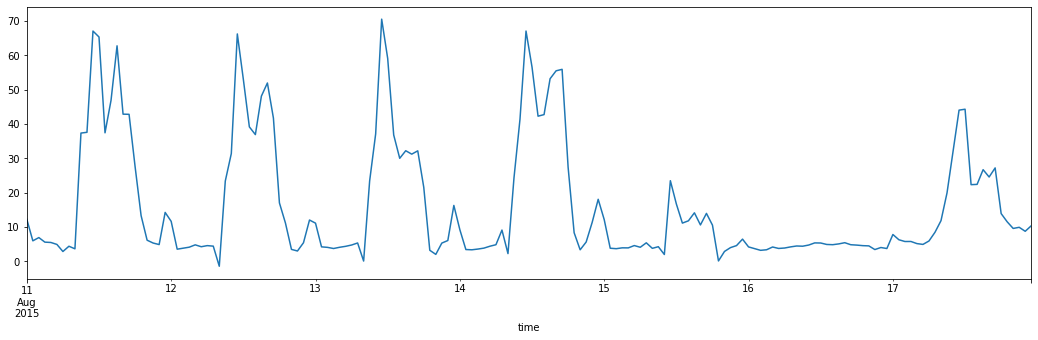

In [64]:
total_pred = (total_pred1 + total_pred2 + total_pred3 + total_pred4) / 4
total_pred[120:144] = total_pred2[120:144]

old_data = pd.read_csv("../data/submit_2023-04-26T10-59.csv")
delta = total_pred - old_data["total"].values
total_pred = total_pred + 2 * delta

data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"] = total_pred
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18, 5))

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [65]:
results = DataFrame(index=pd.date_range(start="2015-08-11 00:00:00", end="2015-08-17 23:00:00", freq="1H"))
results['socket'] = clip_value(socket_pred, _min_val_=0)
results['light'] = clip_value(light_pred, _min_val_=0)
results['air'] = clip_value(air_pred, _min_val_=0)
results['total'] = clip_value(total_pred, _min_val_=0)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

,total,socket,light,air
2015-08-11 00:00:00,12.238448,0.780185,0.995319,7.099217
2015-08-11 01:00:00,5.974360,0.565047,0.431791,4.617763
2015-08-11 02:00:00,6.917476,0.596414,0.420086,4.741299
2015-08-11 03:00:00,5.590386,0.534110,0.379857,4.517027
2015-08-11 04:00:00,5.492790,0.560127,0.395044,4.540367
...,...,...,...,...
2015-08-17 19:00:00,11.514555,1.238140,3.579873,10.429389
2015-08-17 20:00:00,9.578973,1.033117,1.775990,7.510815
2015-08-17 21:00:00,9.909278,1.032493,1.331021,7.507400
2015-08-17 22:00:00,8.748711,0.969820,1.233292,7.609368


In [66]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)